In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install shap
import shutil
import os
import numpy as np
from scipy.stats import pearsonr
from glob import glob
import re
import pandas as pd

#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def gen_df(path):
    '''
    Function to generate data from path
    
    returns Pandas dataframe
    '''
    radius=float(re.findall("\d+\.\d+", os.path.basename(os.path.normpath(path)).split('_')[-1].split()[0])[0])
    data=[]
    mat_keys=[]
    with open(path,'r') as f:
        # Read file
        FILE = f.readlines()

        # Grab easy features
        for idx,i in enumerate(FILE):
            if len(i.split())!=0:
                fltfinder=re.findall('-?\d+\.?\d*', i.split()[-1])
                if '==> v2RDM' in i and 'Violation' not in i:
                    mat_keys.append((idx,''.join(i.split()[1:3])))
                if len(fltfinder)==1:
                    flt=float(fltfinder[0])
                    if 'DETCI' in i or 'HF' in i:
                        data.append(('DETCI@energy', flt))
                    if 'v2RDM' in i:
                        data.append((''.join(i.split()[0:2]),flt))

        og_data = dict(data)            
        # Dictionary with keys and indices for the matrices     
        mat_dict=dict(mat_keys)   

        result = {}

        for key,value in mat_dict.items():
            if value not in result.values():
                result[key] = value

        mat_dict=result

    return pd.DataFrame.from_dict(og_data,orient='index',columns=[radius])    

def collate_data(paths):
    '''
    Create a Pandas dataframe from all the available data
    '''
    cd = pd.concat([gen_df(i) for i in paths],axis=1).sort_index(axis=1)
    return cd.T.loc[:,~cd.T.columns.duplicated()].T

def Energies(data):
    '''
    Collate dataframe
    '''
    cd=collate_data(data)
    return cd.loc['DETCI@energy'],cd.loc['v2RDM@energy']

def genXy(data):
    ''' 
    Seperate targets (y) from features (X)
    '''
    cd=collate_data(data)
    
    y=cd.loc['DETCI@energy']-cd.loc['v2RDM@energy']
    X=cd.drop(['DETCI@energy','v2RDM@energy','v2RDM@Nalpha','v2RDM@Nbeta','v2RDM@Nact','v2RDM@S2']).T
    
    scale_dict={'v2RDM@entropy(D1a)': 'original', 'v2RDM@entropy(D1b)': 'square', 'v2RDM@entropy(Q1a)': 'original', 'v2RDM@entropy(Q1b)': 'original', 'v2RDM@entropy(D2aa)': 'original', 'v2RDM@entropy(D2bb)': 'original', 'v2RDM@entropy(D2ab)': 'original', 'v2RDM@entropy(Q2aa)': 'original', 'v2RDM@entropy(Q2bb)': 'square', 'v2RDM@entropy(Q2ab)': 'square', 'v2RDM@entropy(G2ab)': 'original', 'v2RDM@entropy(G2ba)': 'original', 'v2RDM@entropy(G2aa/bb)': 'original', 'v2RDM@Violation%(T1)': 'sin', 'v2RDM@Violation%(T2)': 'square', 'v2RDM@AveViolation(T1)': 'exp', 'v2RDM@AveViolation(T2)': 'exp', 'v2RDM@RMSViolation(T1)': 'tanh', 'v2RDM@RMSViolation(T2)': 'tanh', 'v2RDM@VarViolation(T1)': 'tanh', 'v2RDM@VarViolation(T2)': 'tanh', 'v2RDM@||del2(aa)||^2': 'tanh', 'v2RDM@||del2(bb)||^2': 'tanh', 'v2RDM@||del2(ab)||^2': 'sin', 'v2RDM@Tr[del2(aa)]': 'tanh', 'v2RDM@Tr[del2(bb)]': 'tanh', 'v2RDM@Tr[del2(ab)]': 'square'}
    scaled_X=X.copy()
    for k,v in scale_dict.items():
        if v!='original':
            scaled_X[k]=scaled_X[k].apply(lambda x: getattr(np,v)(x))
            
    return X,y

In [3]:
systems=sorted([i.split('/')[-1] for i in glob('/Users/voglab04/DDv2RDM/singlet_doublet/*/*')])
spins=['singlet_doublet','triplet_quartet']
basissets=['STO-3G','6-31G','cc-PVDZ']

In [4]:
# Grab spins
s2_dict={sp:{sy:{bs:gen_df(glob(f'/Users/voglab04/DDv2RDM/{sp}/v2rdm_ontop_fci_eval_t1t2/{sy}/{bs}/*')[0]).loc['v2RDM@S2'].to_numpy() for bs in basissets} for sy in systems} for sp in spins}
alpha_dict={sp:{sy:{bs:gen_df(glob(f'/Users/voglab04/DDv2RDM/{sp}/v2rdm_ontop_fci_eval_t1t2/{sy}/{bs}/*')[0]).loc['v2RDM@Nalpha'].to_numpy() for bs in basissets} for sy in systems} for sp in spins}
beta_dict={sp:{sy:{bs:gen_df(glob(f'/Users/voglab04/DDv2RDM/{sp}/v2rdm_ontop_fci_eval_t1t2/{sy}/{bs}/*')[0]).loc['v2RDM@Nbeta'].to_numpy() for bs in basissets} for sy in systems} for sp in spins}

In [5]:
groundstates=[]
excitedstates=[]
idxchk=0
for system in systems:
    for basis in basissets:
        sd_DETCI_E,sd_v2RDM_E=Energies(glob(f'/Users/voglab04/DDv2RDM/{spins[0]}/v2rdm_ontop_fci_eval_t1t2/{system}/{basis}/*'))
        tq_DETCI_E,tq_v2RDM_E=Energies(glob(f'/Users/voglab04/DDv2RDM/{spins[1]}/v2rdm_ontop_fci_eval_t1t2/{system}/{basis}/*'))
        if sd_DETCI_E.min()<tq_DETCI_E.min():
            # print(system,basis,sd_DETCI_E.min(),tq_DETCI_E.min())
            groundstates.append(('singlet_doublet',system,basis))
            excitedstates.append(('triplet_quartet',system,basis))
        else:
            groundstates.append(('triplet_quartet',system,basis))
            excitedstates.append(('singlet_doublet',system,basis))

In [6]:
rads=[]
basis='STO-3G'
for st,sy,bs in tqdm(groundstates+excitedstates, desc='Data', position=0, leave=True):
    if bs==basis:
        rads.append((sy+'_'+st,genXy(glob(f'/Users/voglab04/DDv2RDM/{st}/v2rdm_ontop_fci_eval_t1t2/{sy}/{bs}/*'))))
    
system_dict=dict(rads)        

Data:   0%|          | 0/216 [00:00<?, ?it/s]

In [7]:
violations=['v2RDM@RMSViolation(T1)','v2RDM@RMSViolation(T2)']

In [8]:
popped={}
for k,v in system_dict.copy().items():
    if any(v[0][violations].mean()<=1e-6):
        popped[k]=v
        del system_dict[k]
        


In [9]:
gs_df=[]
for st,sy,bs in tqdm(groundstates, desc='Data', position=0, leave=True):
    gs_df.append((st,sy,bs,0.5*int(alpha_dict[st][sy][bs]-beta_dict[st][sy][bs])))
gs_df=pd.DataFrame(gs_df,columns=['spin_dir','system','basis','S'])


es_df=[]
for st,sy,bs in tqdm(excitedstates, desc='Data', position=0, leave=True):
    es_df.append((st,sy,bs,0.5*int(alpha_dict[st][sy][bs]-beta_dict[st][sy][bs])))
es_df=pd.DataFrame(es_df,columns=['spin_dir','system','basis','S'])

es_df['2S+1']=2*es_df['S']+1
gs_df['2S+1']=2*gs_df['S']+1

Data:   0%|          | 0/108 [00:00<?, ?it/s]

Data:   0%|          | 0/108 [00:00<?, ?it/s]

In [10]:
os.getcwd()

'/Users/voglab04/DDv2RDM/KRR_runs/energystates/both/STO-3G'

In [11]:
es_df.to_excel('/Users/voglab04/DDv2RDM/KRR_runs/energystates/both/STO-3G/es_df.xlsx')
gs_df.to_excel('/Users/voglab04/DDv2RDM/KRR_runs/energystates/both/STO-3G/gs_df.xlsx')

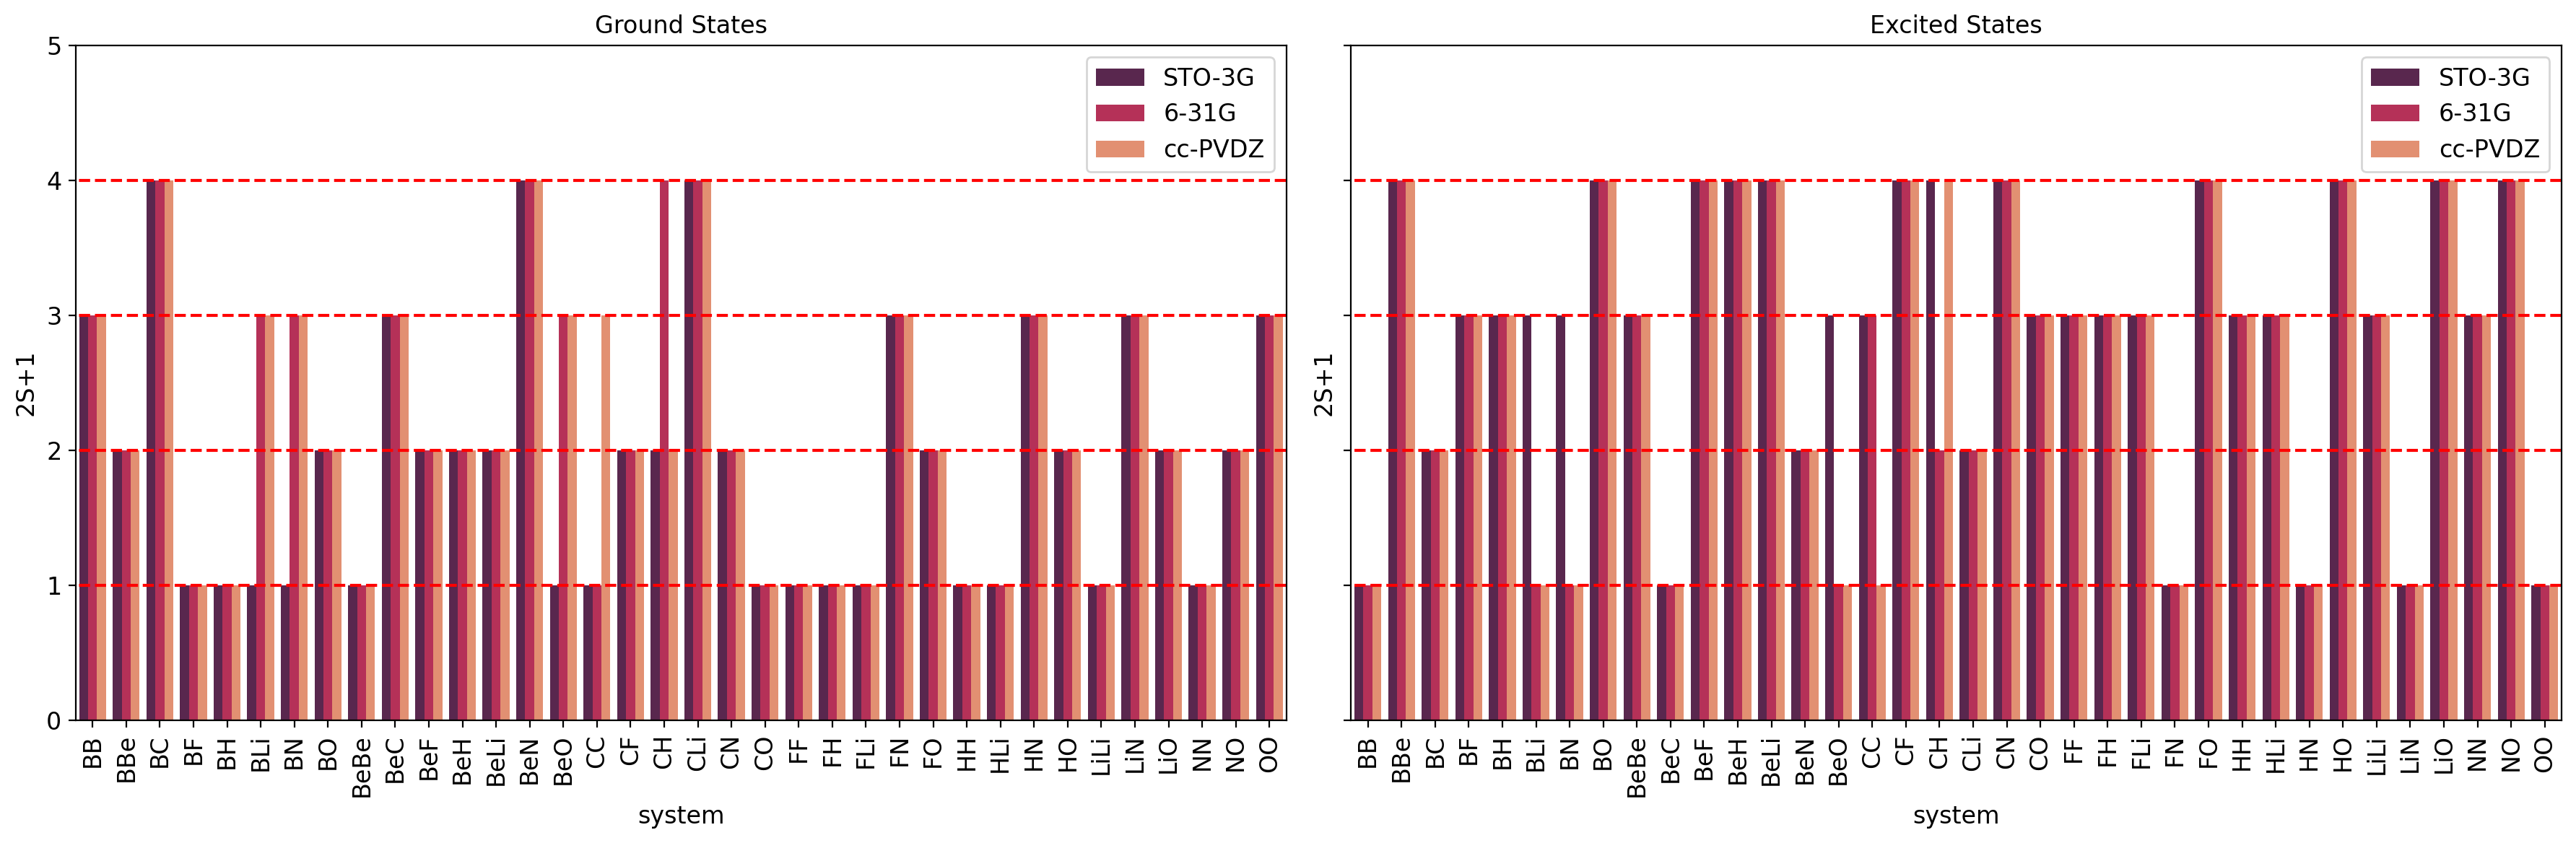

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6), sharey=True)
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title
sns.barplot(data=gs_df,x='system',y='2S+1',hue='basis',ax=ax1,hue_order = ['STO-3G', '6-31G', 'cc-PVDZ'],palette=sns.color_palette('rocket',3))
# ,palette=sns.color_palette('rocket_r',3)
ax1.set_title('Ground States')
ax1.legend(loc=1)
ax1.axhline(1,xmin=-10,xmax=36,color='red',linestyle='--',label='Singlet')
ax1.axhline(2,xmin=-10,xmax=36,color='red',linestyle='--',label='Doublet')
ax1.axhline(3,xmin=-10,xmax=36,color='red',linestyle='--',label='Triplet')
ax1.axhline(4,xmin=-10,xmax=36,color='red',linestyle='--',label='Quintet')


ax1.tick_params(axis='x', labelrotation = 90)

ax1.set_ylim(0,5)

sns.barplot(data=es_df,x='system',y='2S+1',hue='basis',ax=ax2,hue_order = ['STO-3G', '6-31G', 'cc-PVDZ'],palette=sns.color_palette('rocket',3))
ax2.tick_params(axis='x', labelrotation = 90)
ax2.legend(loc=1)
ax2.axhline(1,xmin=-10,xmax=36,color='red',linestyle='--',label='Singlet')
ax2.axhline(2,xmin=-10,xmax=36,color='red',linestyle='--',label='Doublet')
ax2.axhline(3,xmin=-10,xmax=36,color='red',linestyle='--',label='Triplet')
ax2.axhline(4,xmin=-10,xmax=36,color='red',linestyle='--',label='Quintet')
ax2.set_title('Excited States')
plt.tight_layout()
plt.savefig('spin_multiplicities.png',dpi=300,bbox_inches='tight')
plt.show()

In [13]:
# import shap
# # Setup for SHAP
# X = pd.concat([X for k,(X,y) in system_dict.items()])
# y = pd.concat([y for k,(X,y) in system_dict.items()])

# scaler = MinMaxScaler()
# X_scaled=pd.DataFrame(scaler.fit_transform(X),index=X.index,columns = X.columns)

# # model=KernelRidge(alpha=0.01, gamma=0.01, kernel='laplacian').fit(X_train,y_train)
# parameters = {'kernel': ['rbf'],'alpha':np.logspace(-6,6,7),'gamma':np.logspace(-6,6,7)}
# GridSearch = GridSearchCV(KernelRidge(),param_grid=parameters,cv=5,verbose=0).fit(X_scaled,y)
# model=GridSearch.best_estimator_.fit(X_scaled,y)
# model.fit(X_scaled,y)

# # Start SHAP
# explainer = shap.Explainer(model.predict, X_scaled)
# shap_values = explainer(X_scaled)

# # Plot SHAP
# # # Figure Parameters
# fontsize = 12
# plt.rcParams.update({'font.size': fontsize})
# plt.rc('font', size=fontsize)          # controls default text sizes
# plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
# plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
# plt.rc('legend', fontsize=fontsize)    # legend fontsize
# plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title
# plt.rcParams.update({'text.color': "black",'axes.labelcolor': "black"})
# plt.figure(figsize=(4, 3))

# # Plot
# shap.plots.bar(shap_values,max_display=30,show=False)
# plt.ylabel('Features')
# plt.tight_layout()
# plt.savefig('STO-3G_meanabsSHAP.png',dpi=300,bbox_inches='tight')
# plt.show()



# # Figure Parameters
# fontsize = 12
# plt.rcParams.update({'font.size': fontsize})
# plt.rc('font', size=fontsize)          # controls default text sizes
# plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
# plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
# plt.rc('legend', fontsize=fontsize)    # legend fontsize
# plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title
# plt.rcParams.update({'text.color': "black",'axes.labelcolor': "black"})
# plt.figure(figsize=(4, 3))

# # Plot
# shap.plots.beeswarm(shap_values, max_display=30,alpha=0.5,show=False)
# plt.ylabel('Features')
# plt.tight_layout()
# plt.savefig('STO-3G_SHAPvalue.png',dpi=300,bbox_inches='tight')
# plt.show()

In [14]:
# parameters = {'kernel': ['laplacian'],'alpha':np.logspace(-6,6,7),'gamma':np.logspace(-6,6,7)}
# GridSearch = GridSearchCV(KernelRidge(),param_grid=parameters,cv=5,verbose=0).fit(X_train,y_train)
# model=GridSearch.best_estimator_.fit(X_train,y_train)
key_train={}
key_test={}
X_train=[]
y_train=[]

X_test=[]
y_test=[]



for k,(X,y) in system_dict.items():
    train,test=list(y.index[0::2]),list(y.index[1::2])
    key_train[k]=train
    key_test[k]=test    
    X_train.append(X.loc[train])
    y_train.append(pd.DataFrame(y.loc[train]).rename(columns={0:k}))
    X_test.append(X.loc[test])
    y_test.append(pd.DataFrame(y.loc[test]).rename(columns={0:k}))
    
X_train=pd.concat(X_train)
ytraindf=pd.concat(y_train,axis=1)

X_test=pd.concat(X_test)
ytestdf=pd.concat(y_test,axis=1)








trainidx=X_train.index
traincol=X_train.columns

testidx=X_test.index
testcol=X_test.columns

y_train=ytraindf
y_test=ytestdf


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.T.stack().to_numpy()
y_test = y_test.T.stack().to_numpy()

X_train = pd.DataFrame(X_train,index=trainidx,columns=traincol)
X_test = pd.DataFrame(X_test,index=testidx,columns=testcol)


# model=KernelRidge(alpha=0.01, gamma=0.01, kernel='laplacian').fit(X_train,y_train)
parameters = {'kernel': ['rbf'],'alpha':np.logspace(-6,6,7),'gamma':np.logspace(-6,6,7)}
GridSearch = GridSearchCV(KernelRidge(),param_grid=parameters,cv=5,verbose=0).fit(X_train,y_train)
model=GridSearch.best_estimator_.fit(X_train,y_train)




train_pred=model.predict(X_train)
test_pred=model.predict(X_test)

stats={'Train':len(train),
       'Test':len(test),
       'Train MAPE':mean_absolute_percentage_error(y_train,train_pred)*100,
       'Test MAPE':mean_absolute_percentage_error(y_test,test_pred)*100,
       'Train R2':r2_score(y_train,train_pred),
       'Test R2':r2_score(y_test,test_pred),
       'Train MAE':mean_absolute_error(y_train,train_pred),
       'Test MAE':mean_absolute_error(y_test,test_pred),
       'Train RMSE':mean_squared_error(y_train,train_pred, squared=False),
       'Test RMSE':mean_squared_error(y_test,test_pred, squared=False)}

df_stats=pd.DataFrame.from_dict(stats,orient='index')


In [15]:
Y=pd.concat([pd.DataFrame(y,columns=[k]) for k,(X,y) in system_dict.items()],axis=1).melt()
CC_singlet_doublet_idx=Y[Y['variable']=='CC_singlet_doublet'].index

In [50]:
colormap=sns.color_palette('rocket',2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


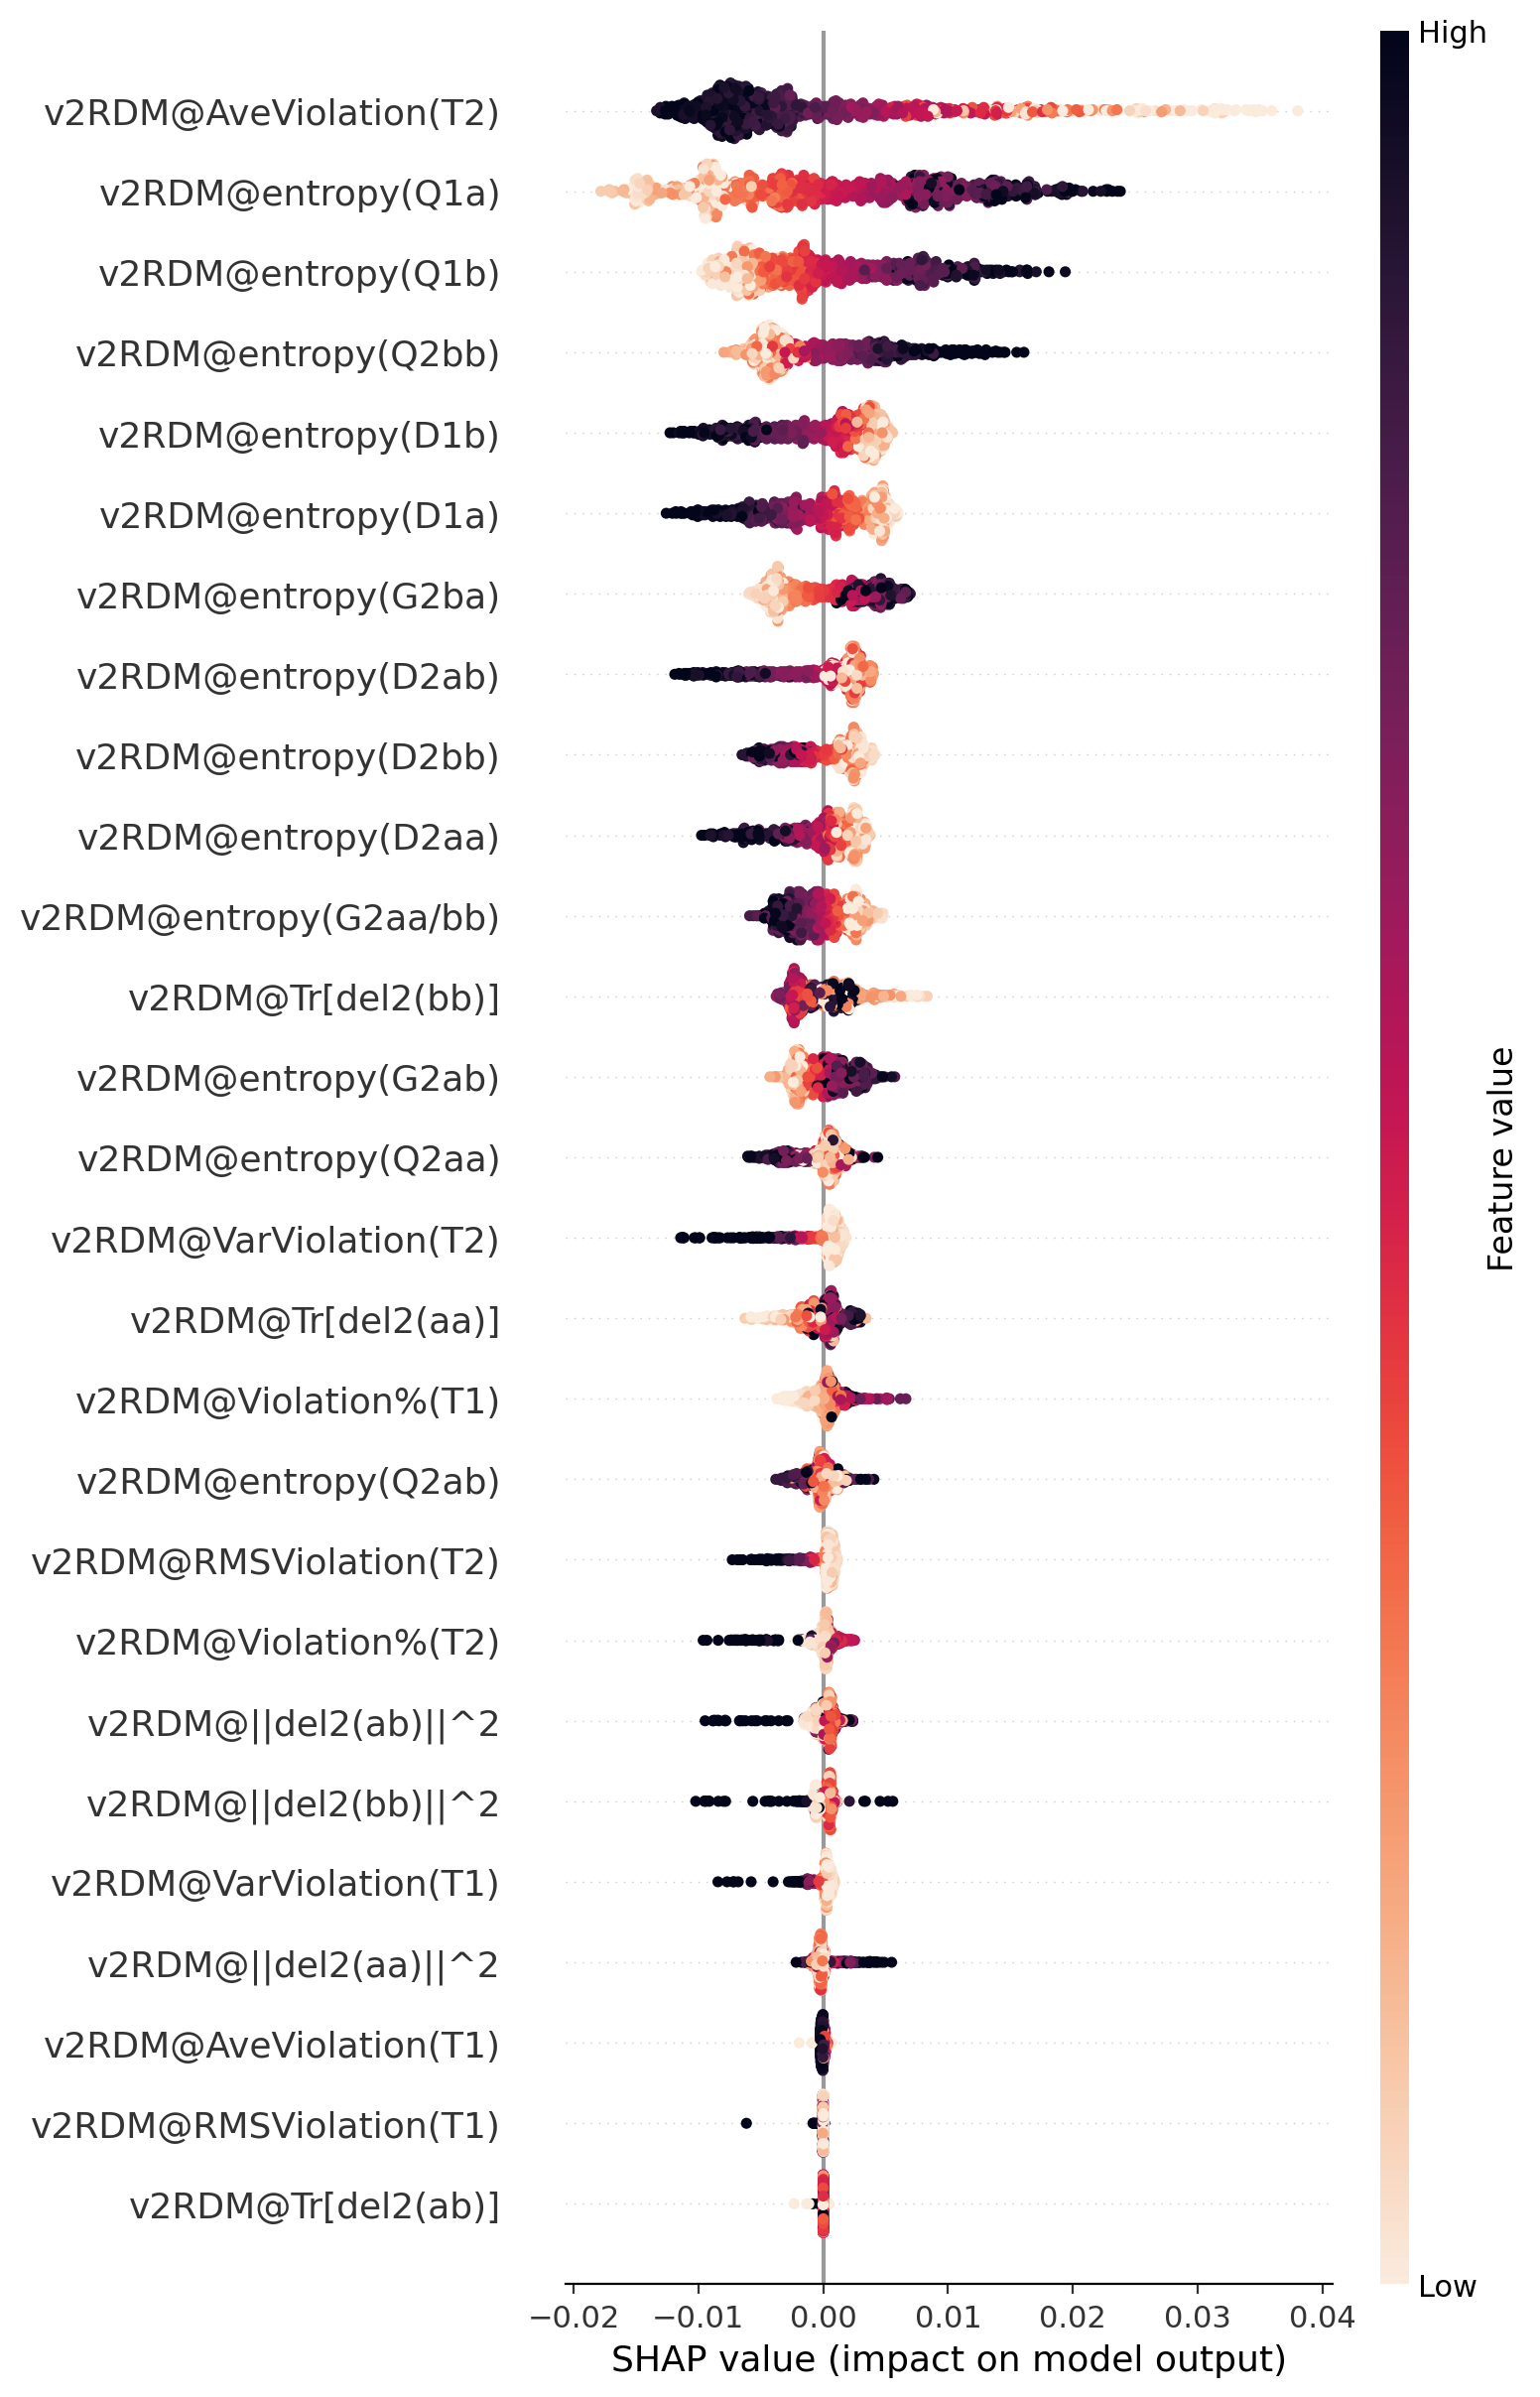

In [48]:
import shap
# # for k,v in all_data.items():
# #     for key in v.keys():
# #         print(k,key.split('_')[0],'_'.join(key.split('_')[1:3]),key)
        
# #         model=basisdata[k][key]['model']
        
# # compute the SHAP values for the linear model
# cc_xtestdf=pd.concat([X for k,(X,y) in system_dict.items()],axis=0)
# # .iloc[CC_singlet_doublet_idx]
# cc_xtest=pd.DataFrame(scaler.transform(cc_xtestdf),columns=cc_xtestdf.columns,index=cc_xtestdf.index)
# explainer = shap.Explainer(model.predict, cc_xtest)
# shap_values = explainer(cc_xtest)

fontsize = 14
plt.rcParams.update({'font.size': fontsize})
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title
shap.plots.beeswarm(shap_values,show=False,max_display=32,color=sns.cm.rocket_r)
plt.tight_layout()
plt.savefig(f'all_STO3G_shapvalues.png',dpi=300,bbox_inches='tight')
plt.show()        


In [17]:
df_stats.rename(columns={0:'Stats'}).to_excel('STO-3G_bigstackstats.xlsx')

In [18]:
ytrain_preddf=pd.DataFrame(train_pred,index=ytraindf.T.stack().index).unstack().T.droplevel(0)


ytest_preddf=pd.DataFrame(test_pred,index=ytestdf.T.stack().index).unstack().T.droplevel(0)

In [19]:
mean_absolute_error(ytraindf['BB_triplet_quartet'].dropna().to_numpy(),ytrain_preddf['BB_triplet_quartet'].dropna().to_numpy())

0.0009057226048340266

<AxesSubplot: xlabel='index', ylabel='0'>

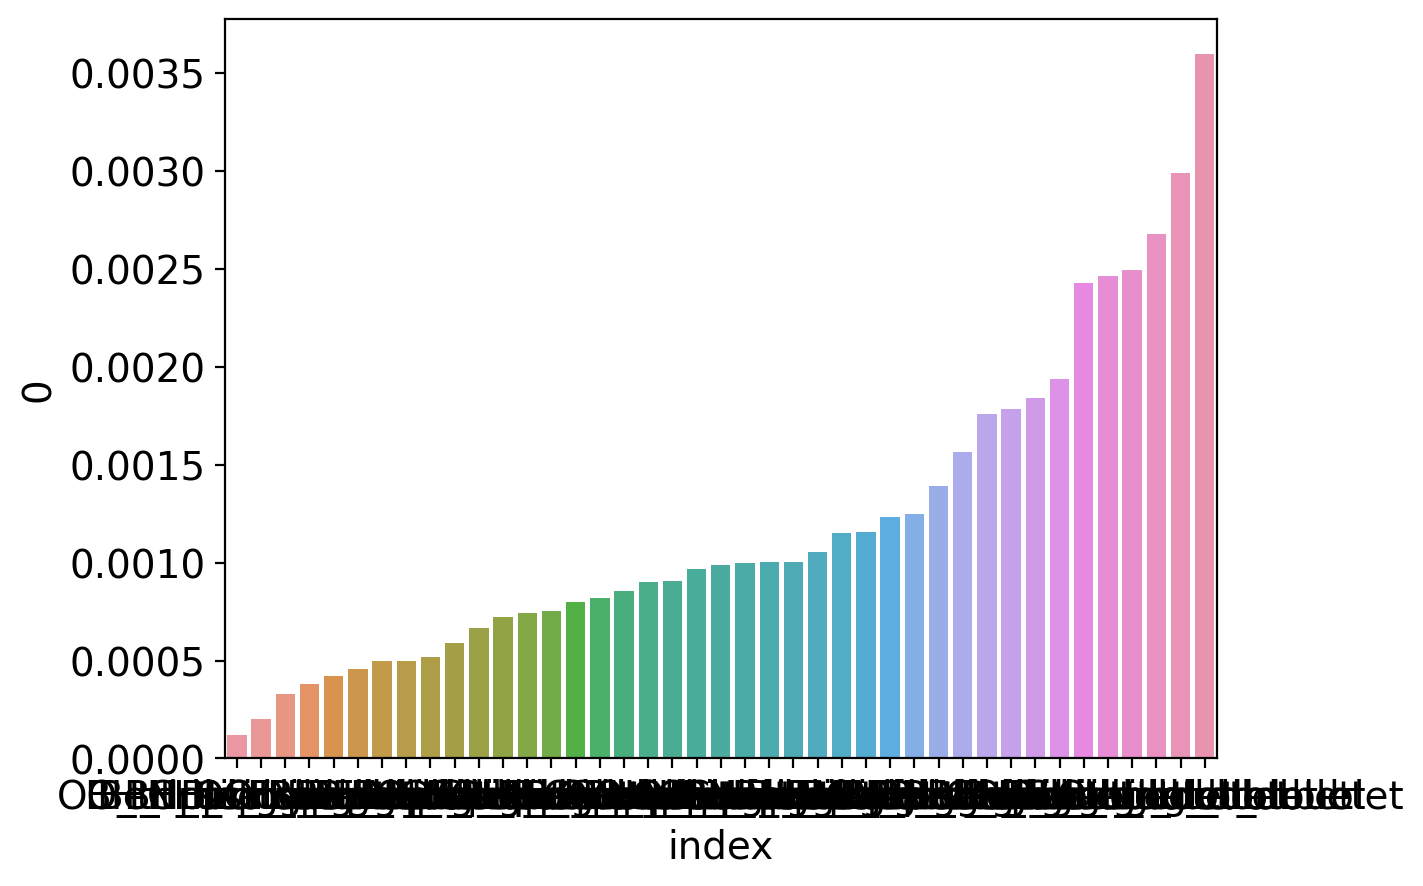

In [20]:
sns.barplot(data=(ytrain_preddf-ytraindf).abs().mean().reset_index().sort_values(by=0),x='index',y=0)

In [21]:
pallete=sns.color_palette('rocket',8)

In [22]:
Y=pd.concat([pd.DataFrame(y,columns=[k]) for k,(X,y) in system_dict.items()],axis=1)
GS_df=pd.concat([Y[f'{nam}_{st}'] for (st,nam,bs) in groundstates if bs==basis and f'{nam}_{st}' in Y.columns],axis=1)
ES_df=pd.concat([Y[f'{nam}_{st}'] for (st,nam,bs) in excitedstates if bs==basis and f'{nam}_{st}' in Y.columns],axis=1)
all_df=pd.concat([GS_df,ES_df],axis=1).sort_index(axis=1)

In [23]:
GS_ytrain_df=ytraindf[GS_df.columns]
ES_ytrain_df=ytraindf[ES_df.columns]
GS_ytrain_preddf=ytrain_preddf[GS_df.columns]
ES_ytrain_preddf=ytrain_preddf[ES_df.columns]


GS_ytest_df=ytestdf[GS_df.columns]
ES_ytest_df=ytestdf[ES_df.columns]
GS_ytest_preddf=ytest_preddf[GS_df.columns]
ES_ytest_preddf=ytest_preddf[ES_df.columns]

In [24]:
GS_melt=GS_df.T.stack().reset_index().rename(columns={'level_0':'Structures','level_1':'Bond Length ($\AA$)',0:'E$_{(CAS-)CI}$-E$_{(CAS-)v2RDM}$'})
ES_melt=ES_df.T.stack().reset_index().rename(columns={'level_0':'Structures','level_1':'Bond Length ($\AA$)',0:'E$_{(CAS-)CI}$-E$_{(CAS-)v2RDM}$'})

In [25]:
GS_energies={nam:dict(zip(['FCI','v2RDM'],Energies(glob(f'/Users/voglab04/DDv2RDM/{st}/v2rdm_ontop_fci_eval_t1t2/{nam}/{bs}/*')))) for (st,nam,bs) in groundstates if bs==basis}
ES_energies={nam:dict(zip(['FCI','v2RDM'],Energies(glob(f'/Users/voglab04/DDv2RDM/{st}/v2rdm_ontop_fci_eval_t1t2/{nam}/{bs}/*')))) for (st,nam,bs) in excitedstates if bs==basis}

In [26]:

sort_train_MAE_GS_r2=sorted([[(r2_score(trainval.dropna().values,predtrainval.dropna().values),predtrainname) for (trainname,trainval) in GS_ytrain_df.items() if trainname==predtrainname] for (predtrainname,predtrainval) in GS_ytrain_preddf.items()])
sort_train_MAE_ES_r2=sorted([[(r2_score(trainval.dropna().values,predtrainval.dropna().values),predtrainname) for (trainname,trainval) in ES_ytrain_df.items() if trainname==predtrainname] for (predtrainname,predtrainval) in ES_ytrain_preddf.items()])
sort_train_MAE_GS_mae=sorted([[(mean_absolute_error(trainval.dropna().values,predtrainval.dropna().values),predtrainname) for (trainname,trainval) in GS_ytrain_df.items() if trainname==predtrainname] for (predtrainname,predtrainval) in GS_ytrain_preddf.items()])
sort_train_MAE_ES_mae=sorted([[(mean_absolute_error(trainval.dropna().values,predtrainval.dropna().values),predtrainname) for (trainname,trainval) in ES_ytrain_df.items() if trainname==predtrainname] for (predtrainname,predtrainval) in ES_ytrain_preddf.items()])


In [27]:
compared_GS_stats={k1:np.array([(v,v1) for v,k in sum(sort_train_MAE_GS_r2,[]) if k==k1]) for v1, k1 in sum(sort_train_MAE_GS_mae,[])}

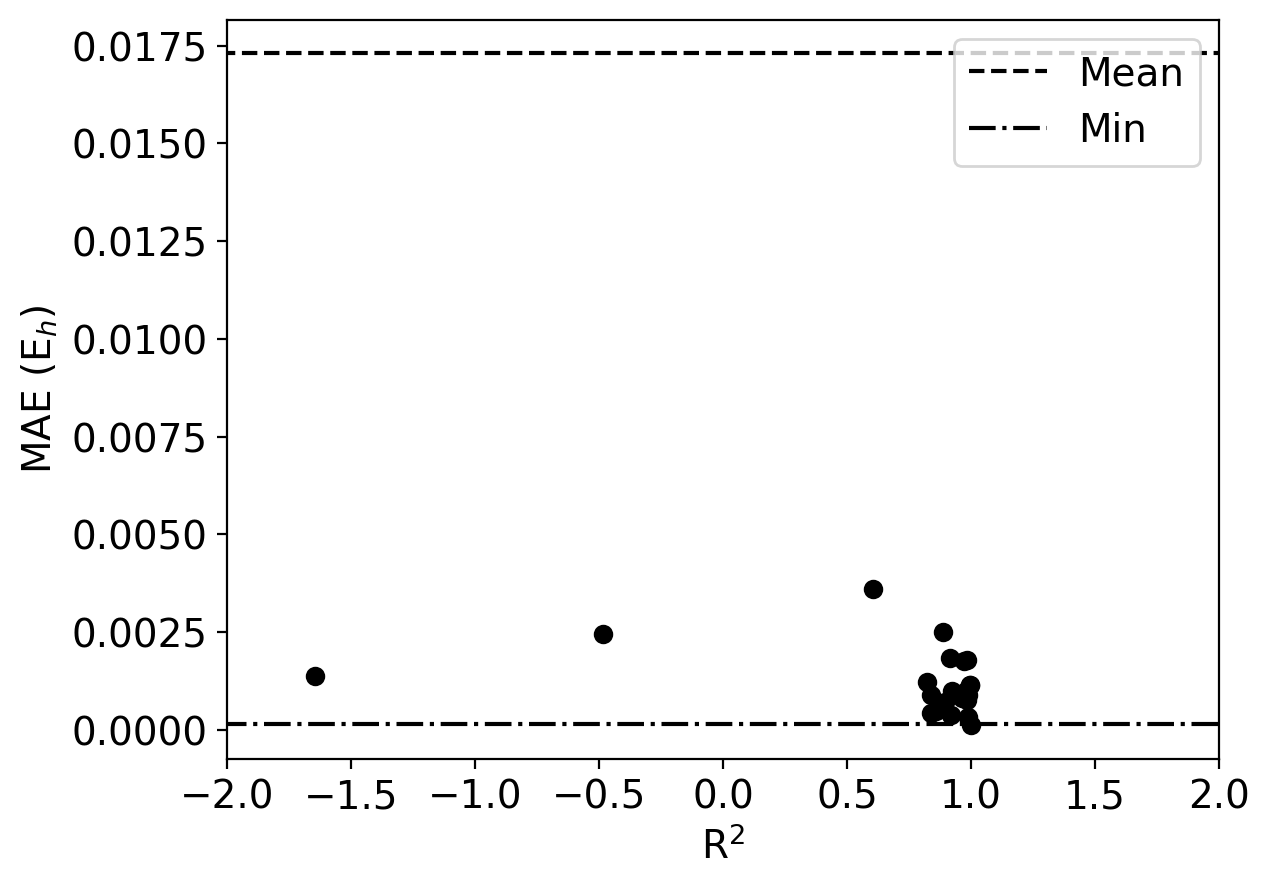

In [28]:
for k,v in compared_GS_stats.items():
    v=v.reshape(-1)
    plt.scatter(v[0],v[1],color='k')
plt.hlines(GS_df.T.stack().to_numpy().mean(),xmin=-4,xmax=3,colors='k',linestyle='--',label='Mean')
plt.hlines(GS_df.T.stack().to_numpy().min(),xmin=-4,xmax=3,colors='k',linestyle='-.',label='Min')
plt.xlim(-2,2)
plt.ylabel('MAE (E$_{h}$)')
plt.xlabel('R$^{2}$')
plt.legend()
plt.show()

In [29]:
max(idx for idx,nam in enumerate(GS_df.columns))

21

BB BB_triplet_quartet BB_singlet_doublet


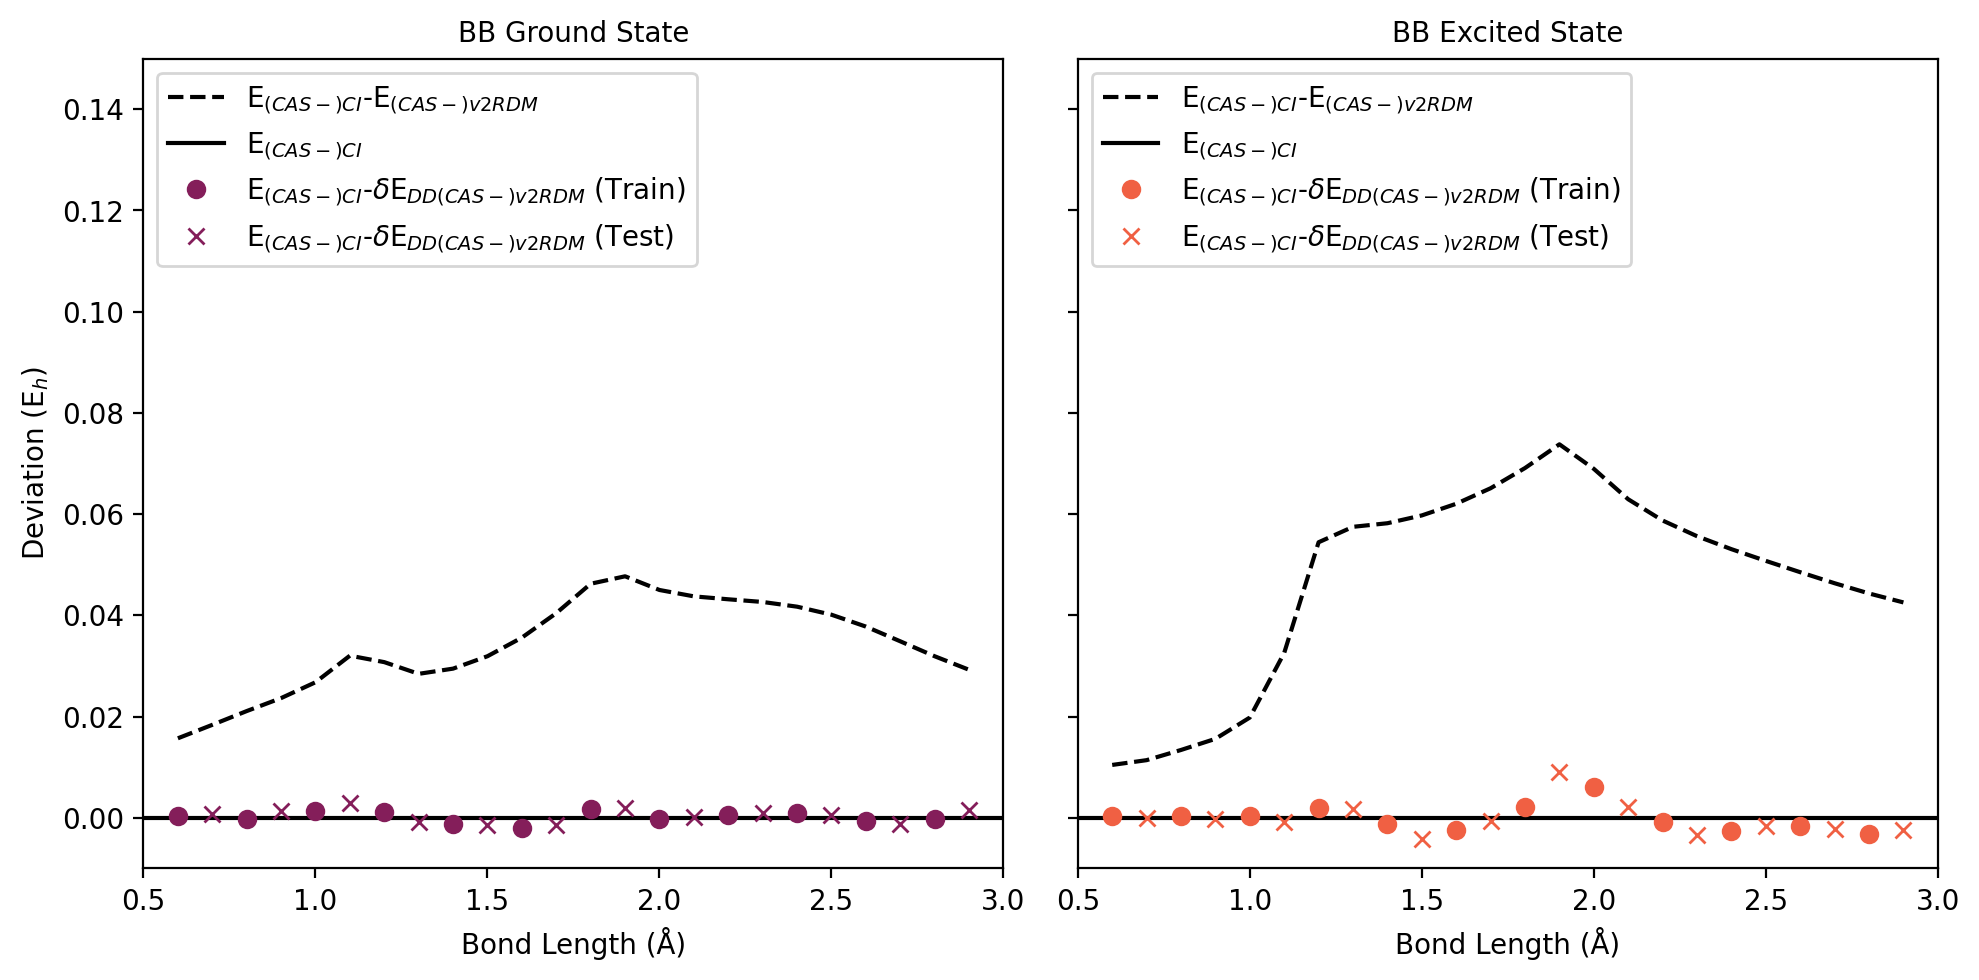

BBe BBe_singlet_doublet BBe_triplet_quartet


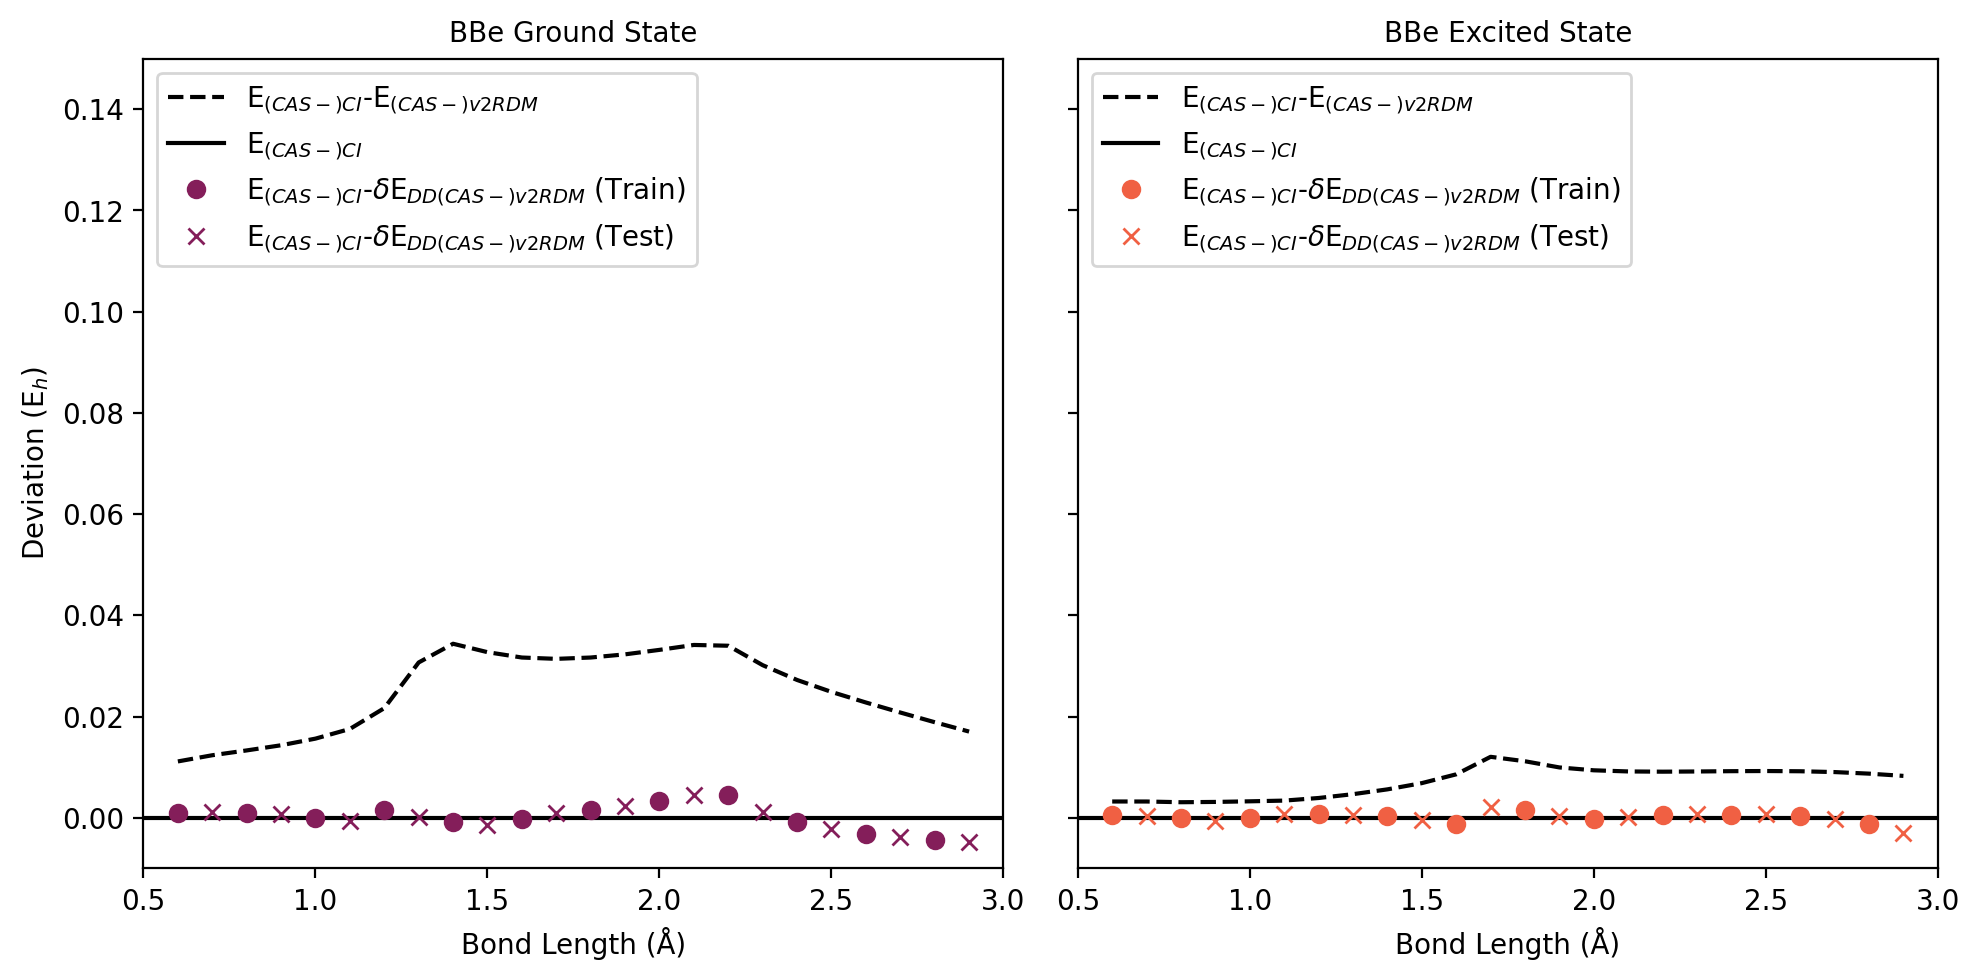

BC BC_triplet_quartet BC_singlet_doublet


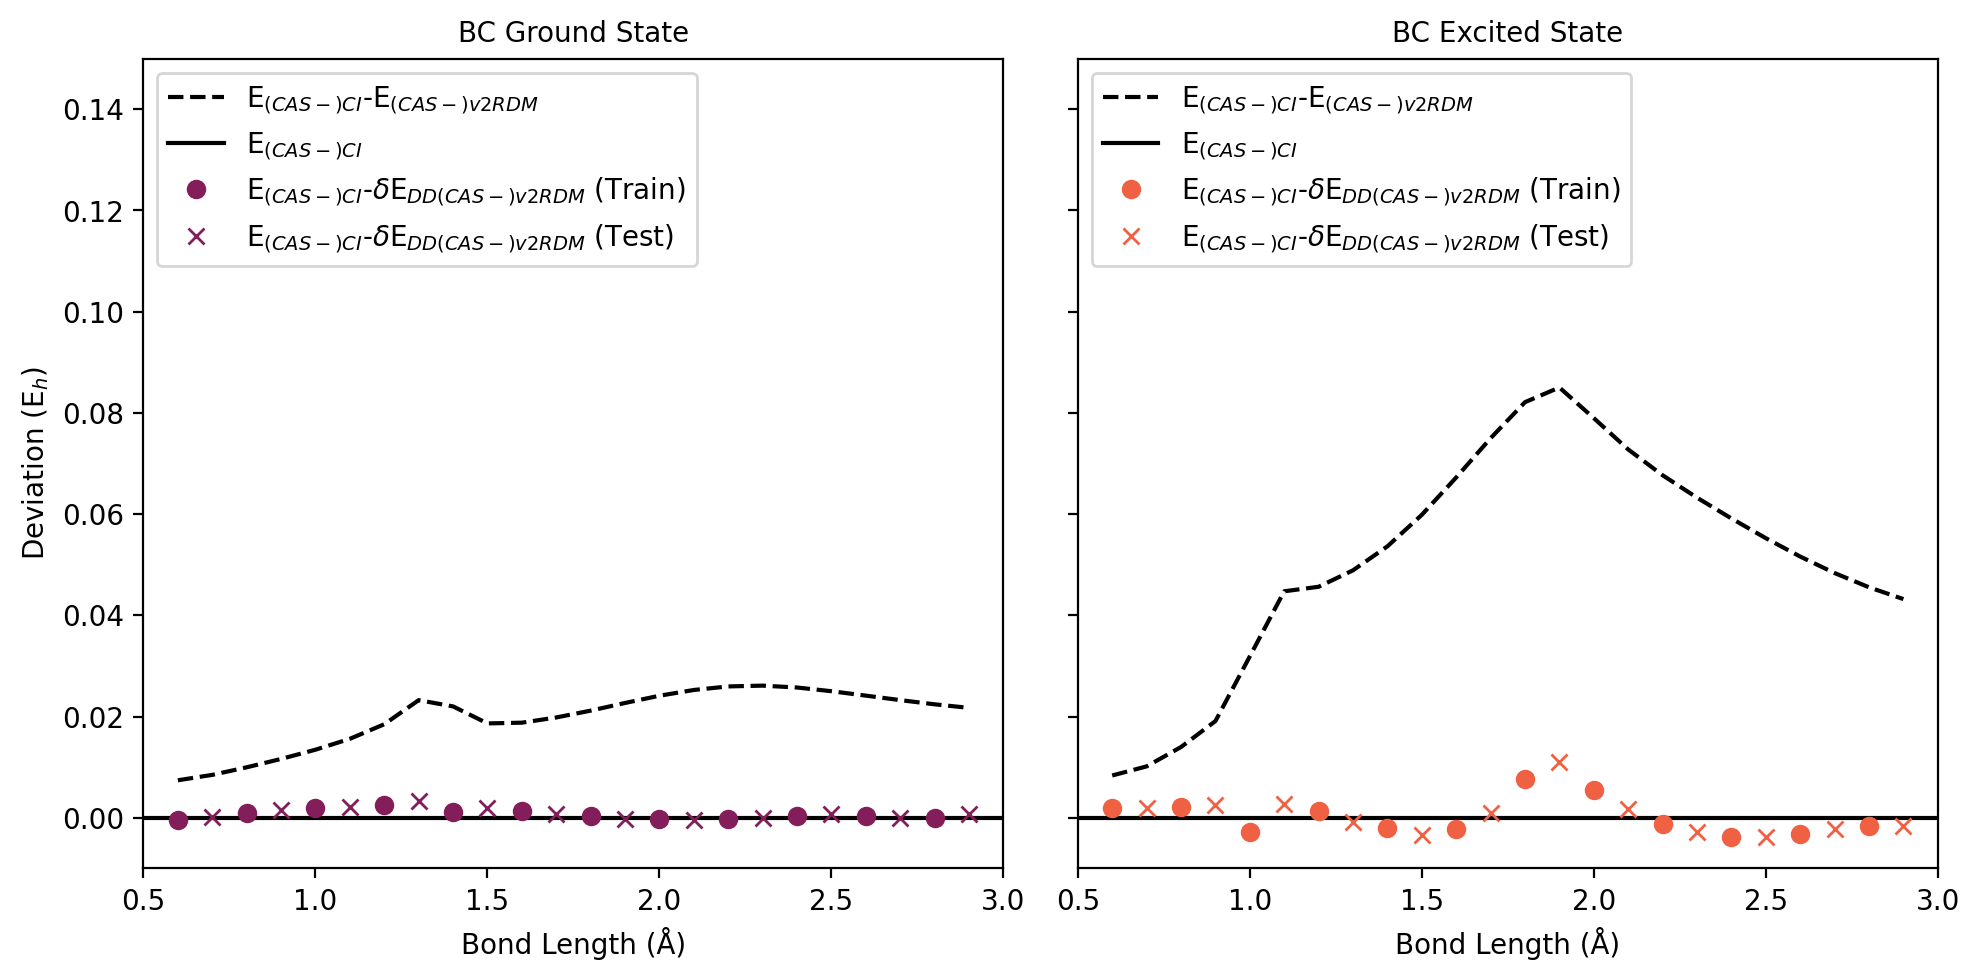

BF BF_singlet_doublet BF_triplet_quartet


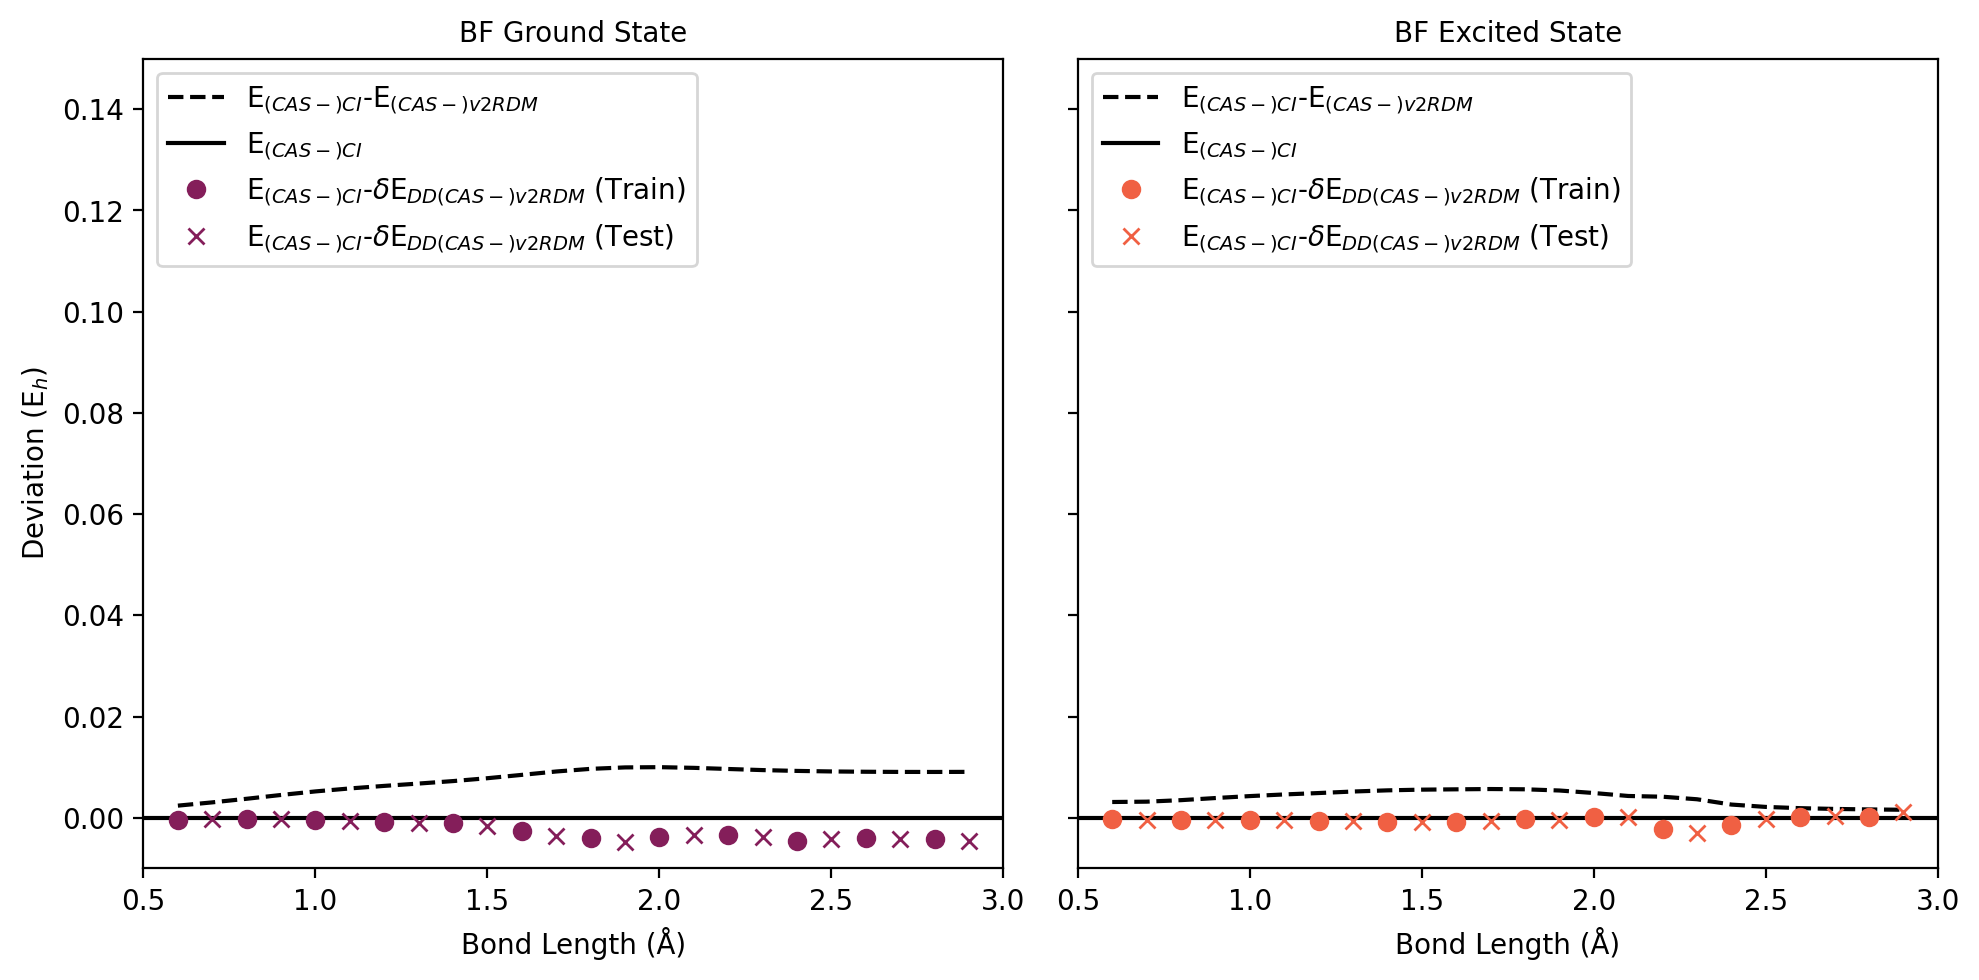

BH BH_singlet_doublet BH_triplet_quartet


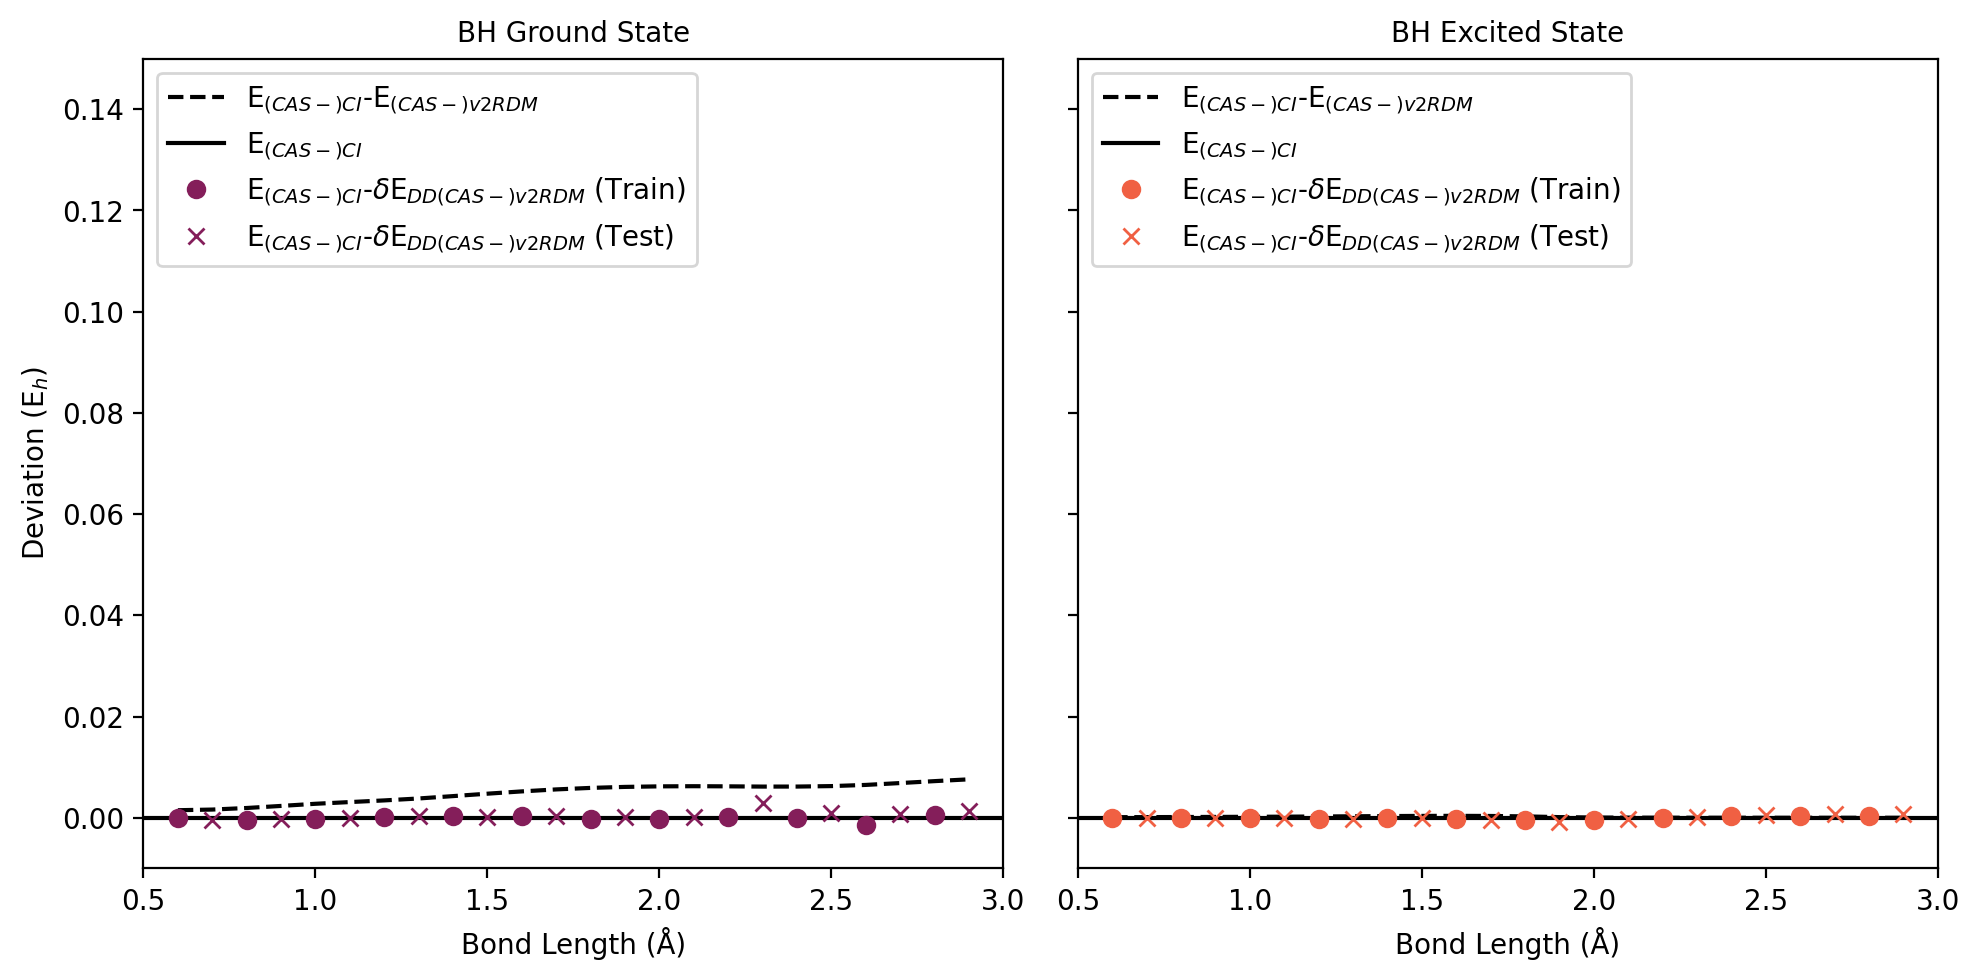

BLi BLi_singlet_doublet BLi_triplet_quartet


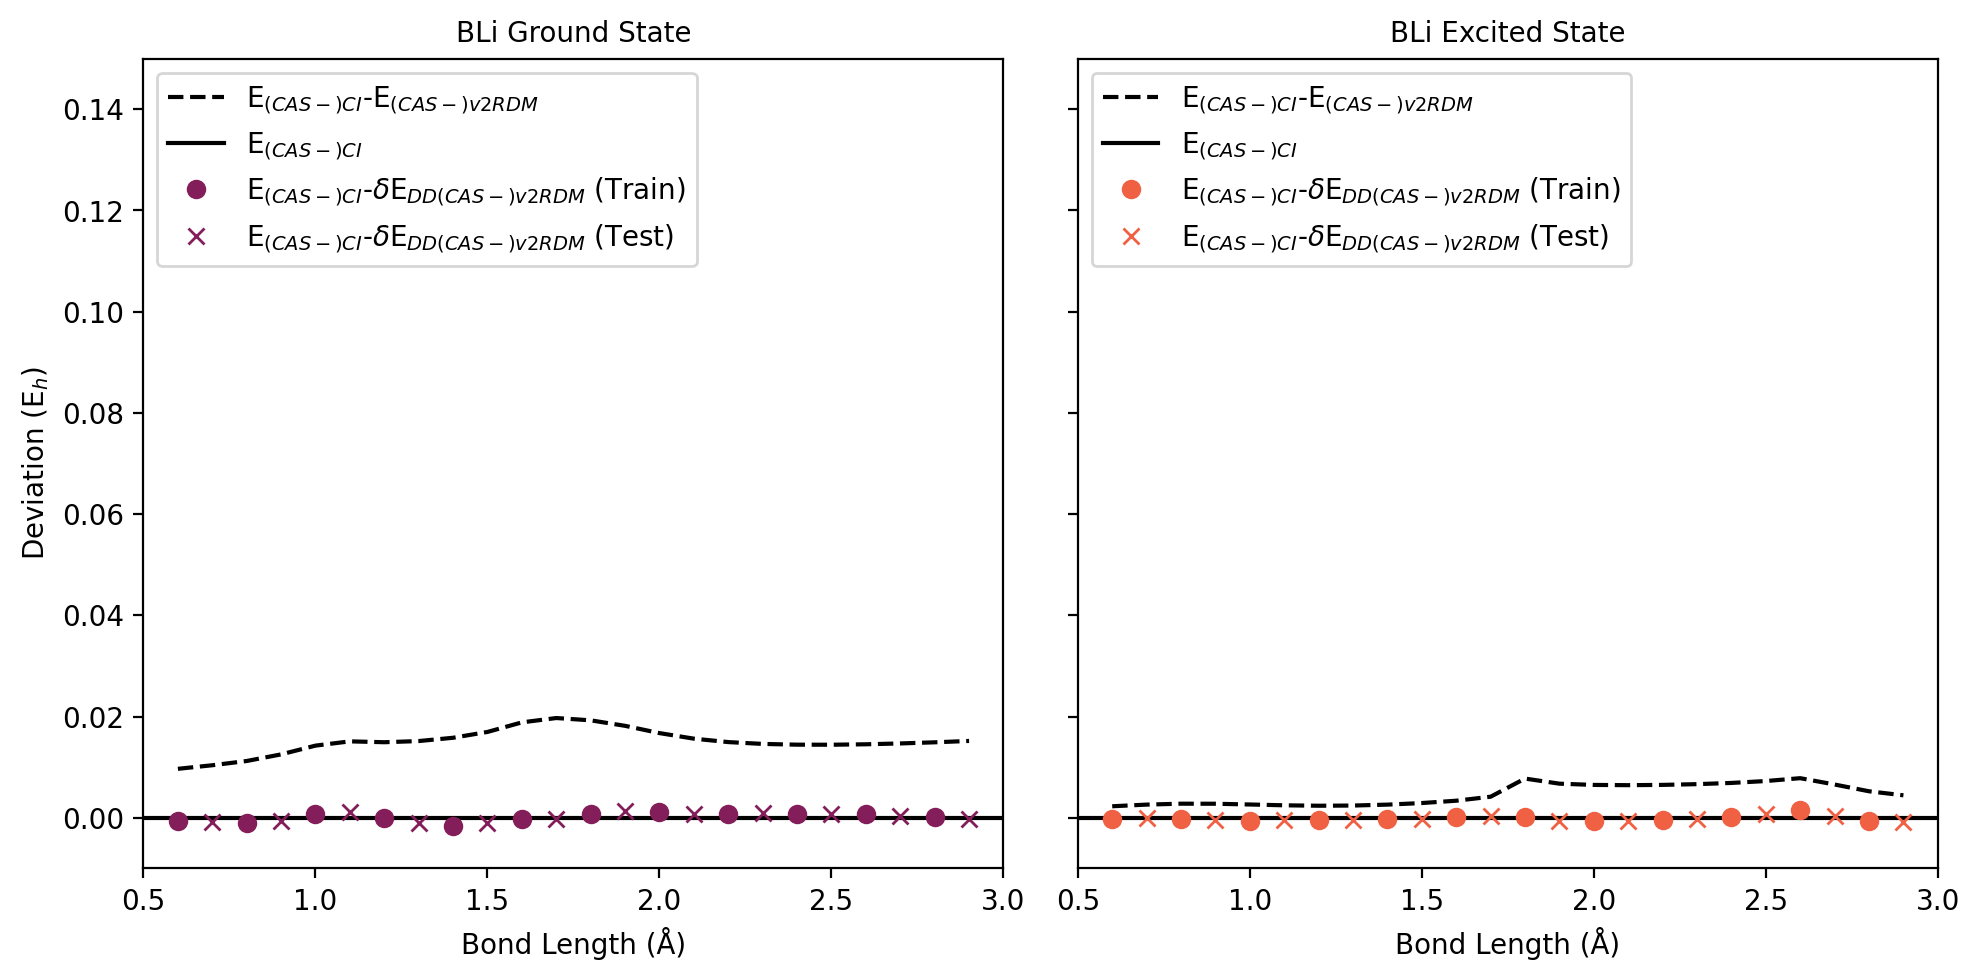

BN BN_singlet_doublet BN_triplet_quartet


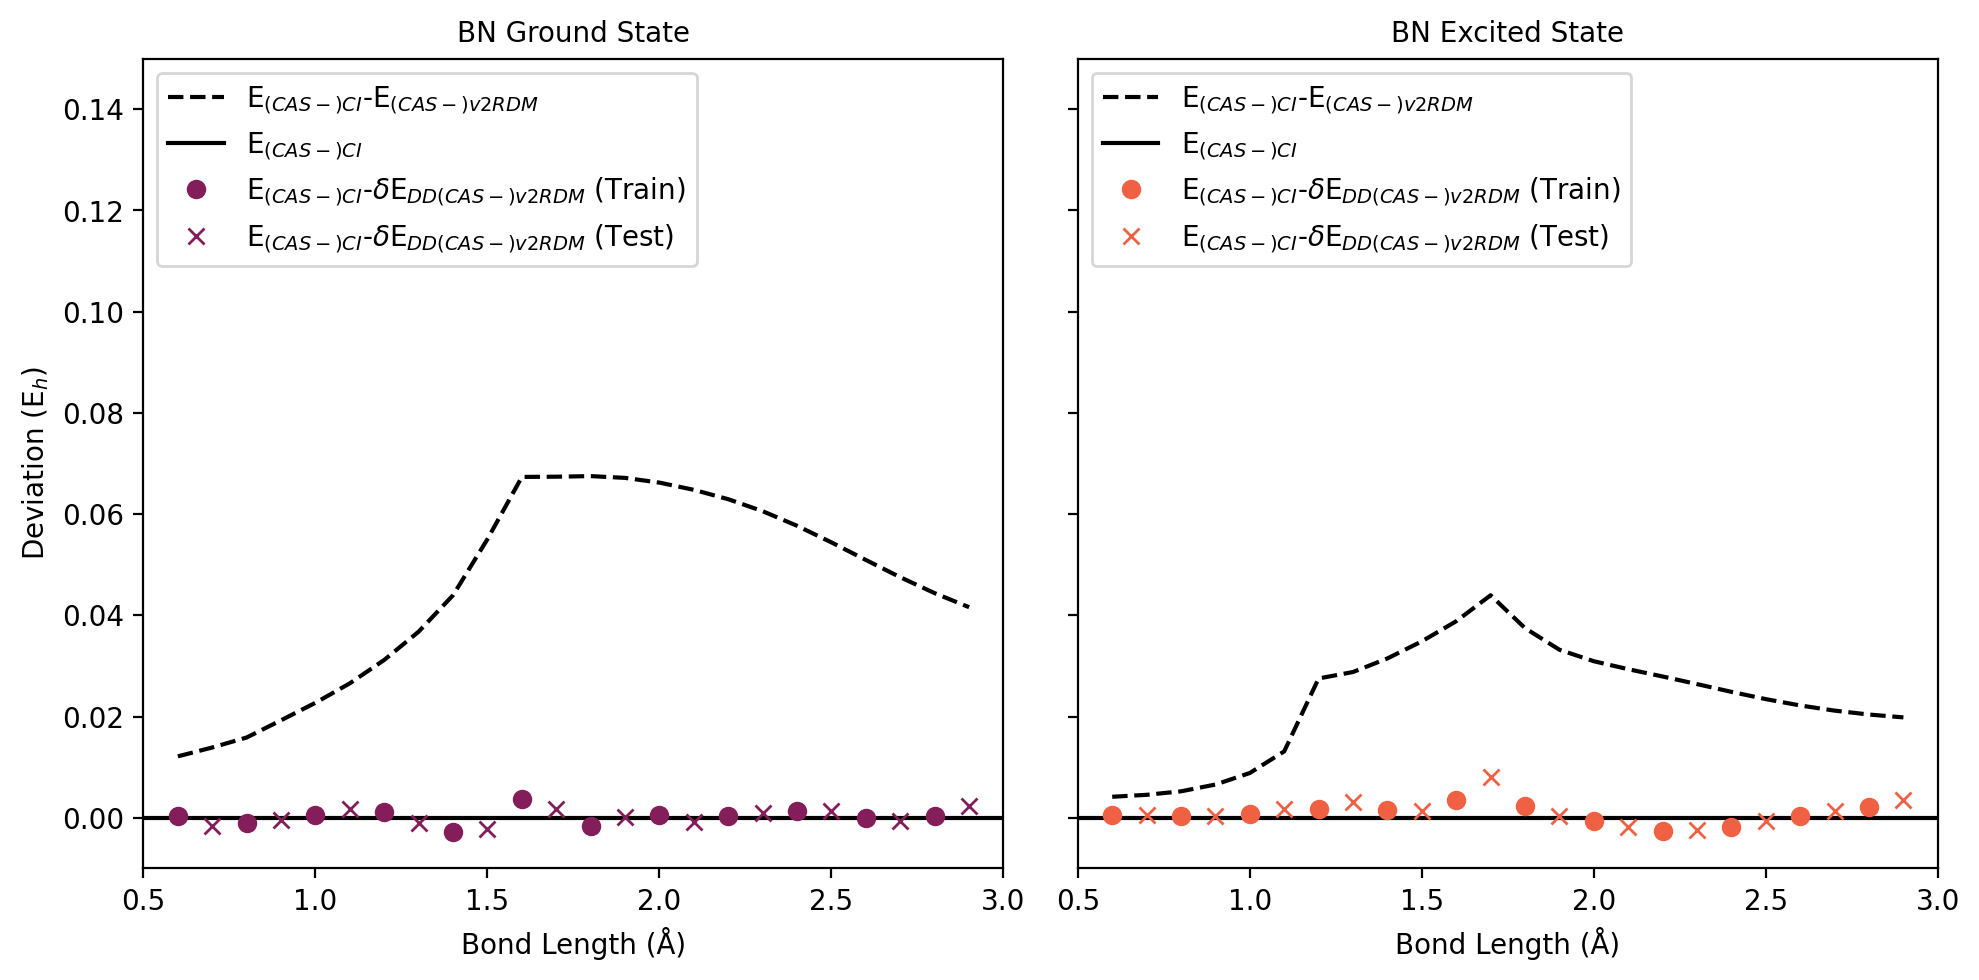

BO BO_singlet_doublet BO_triplet_quartet


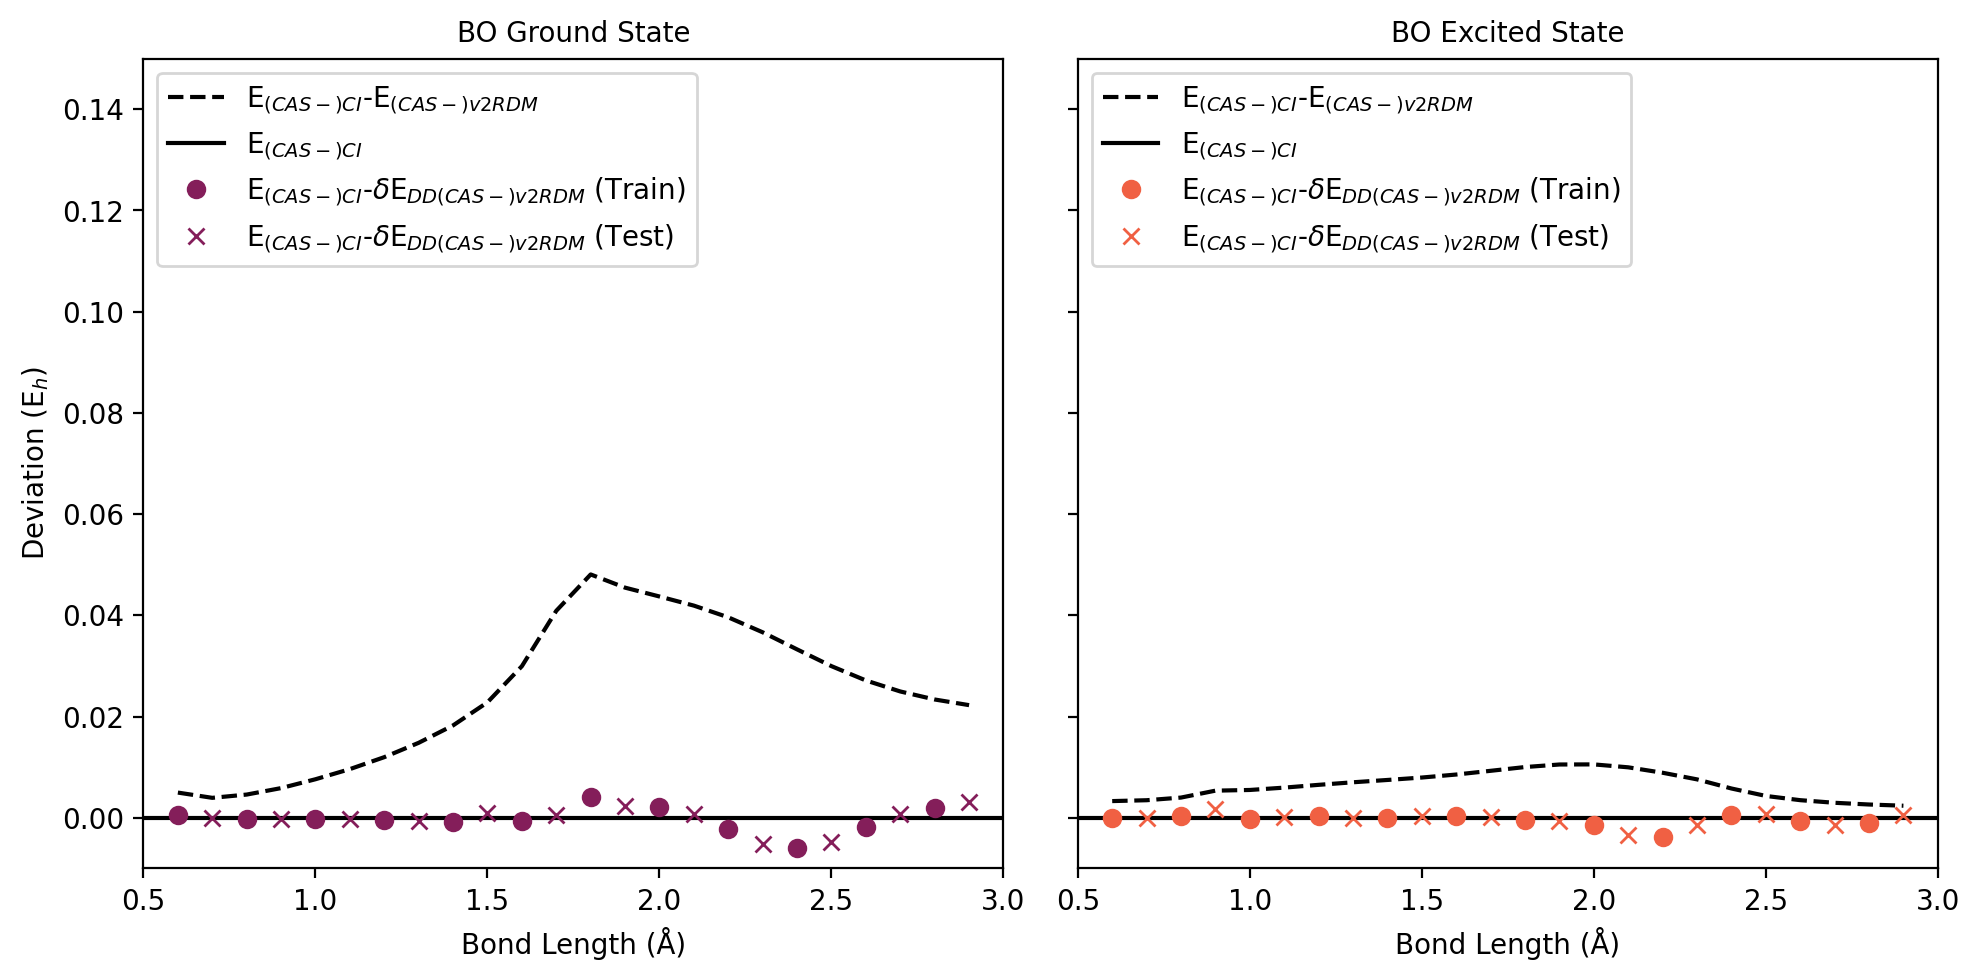

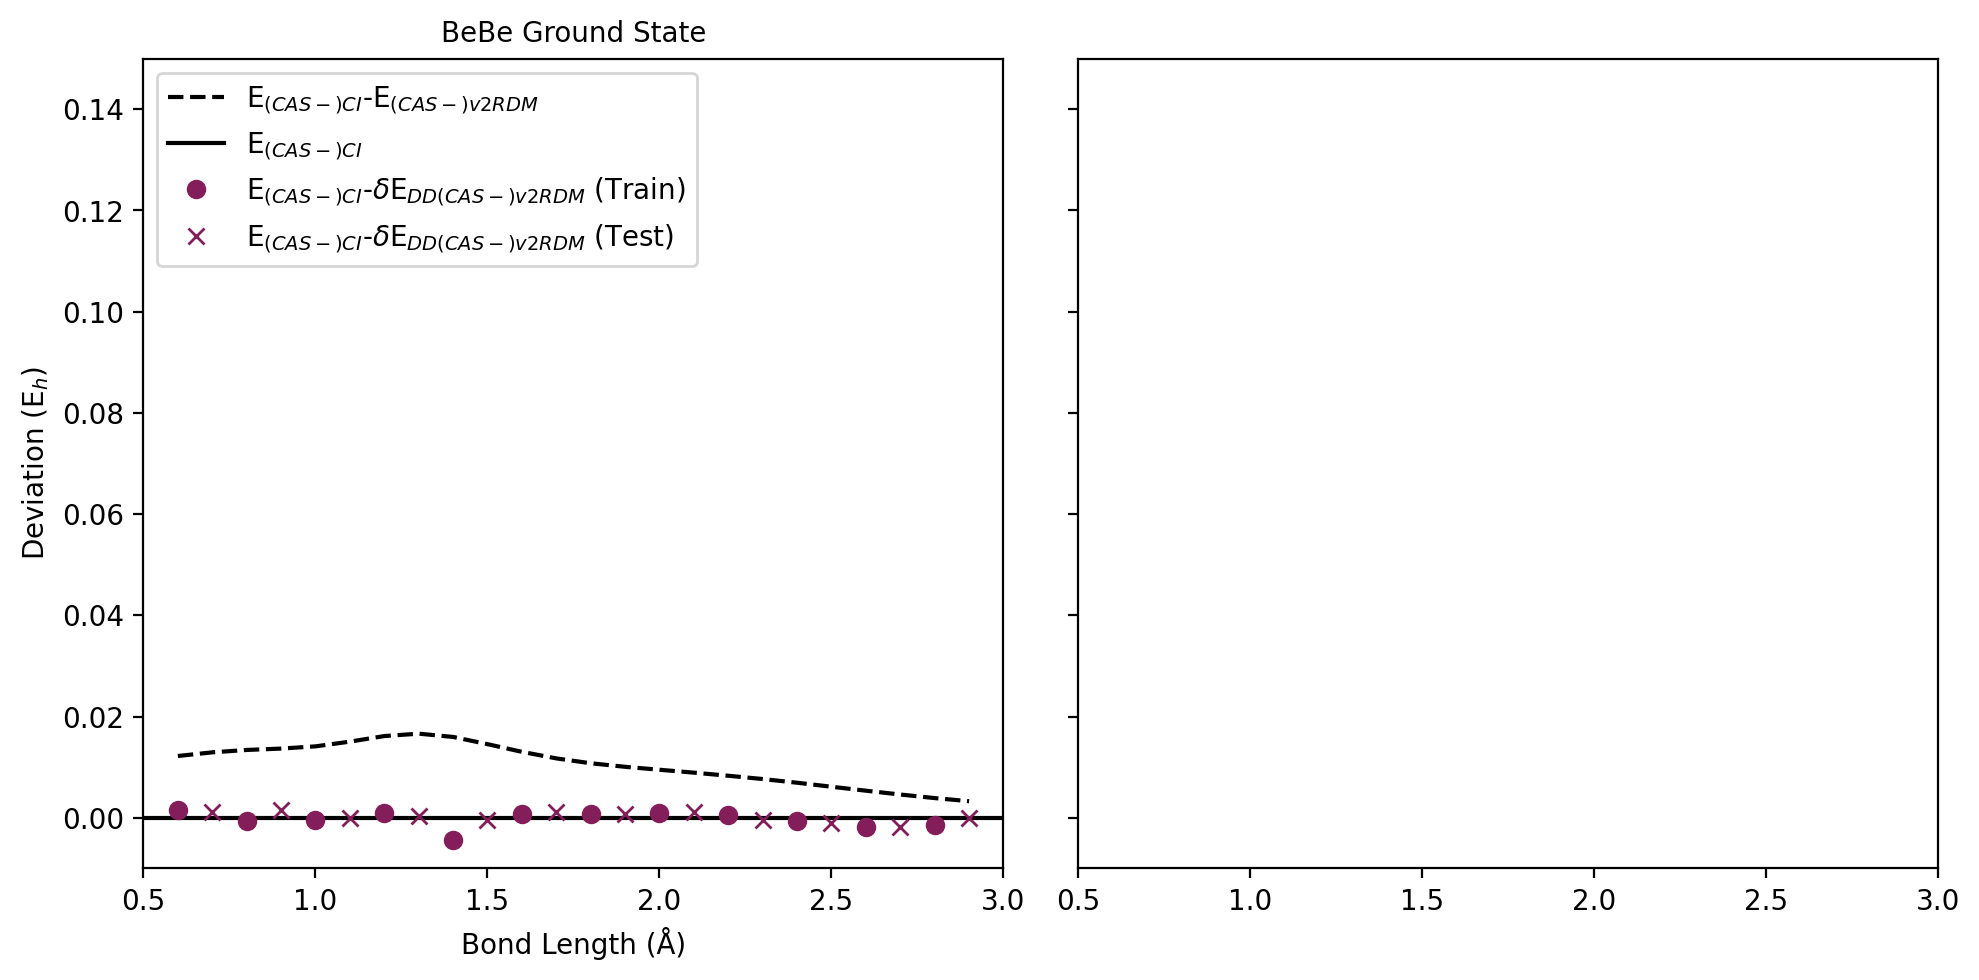

BeC BeC_triplet_quartet BeC_singlet_doublet


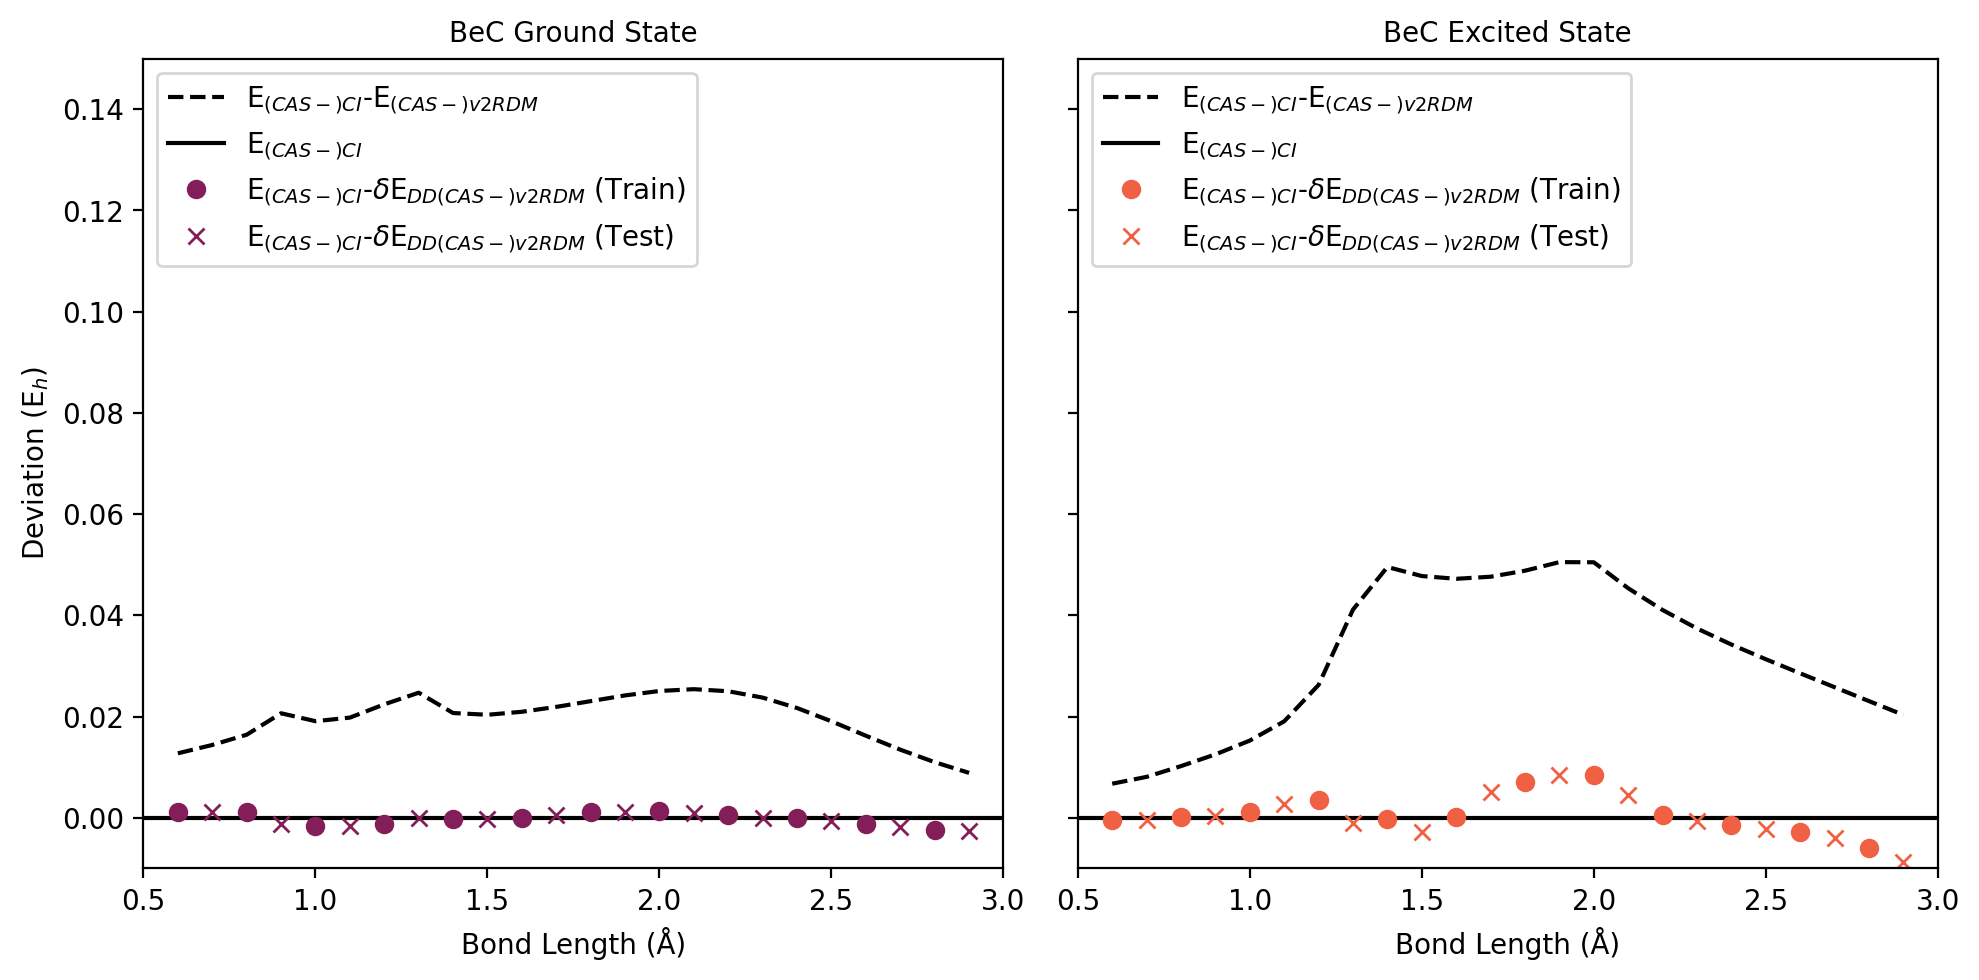

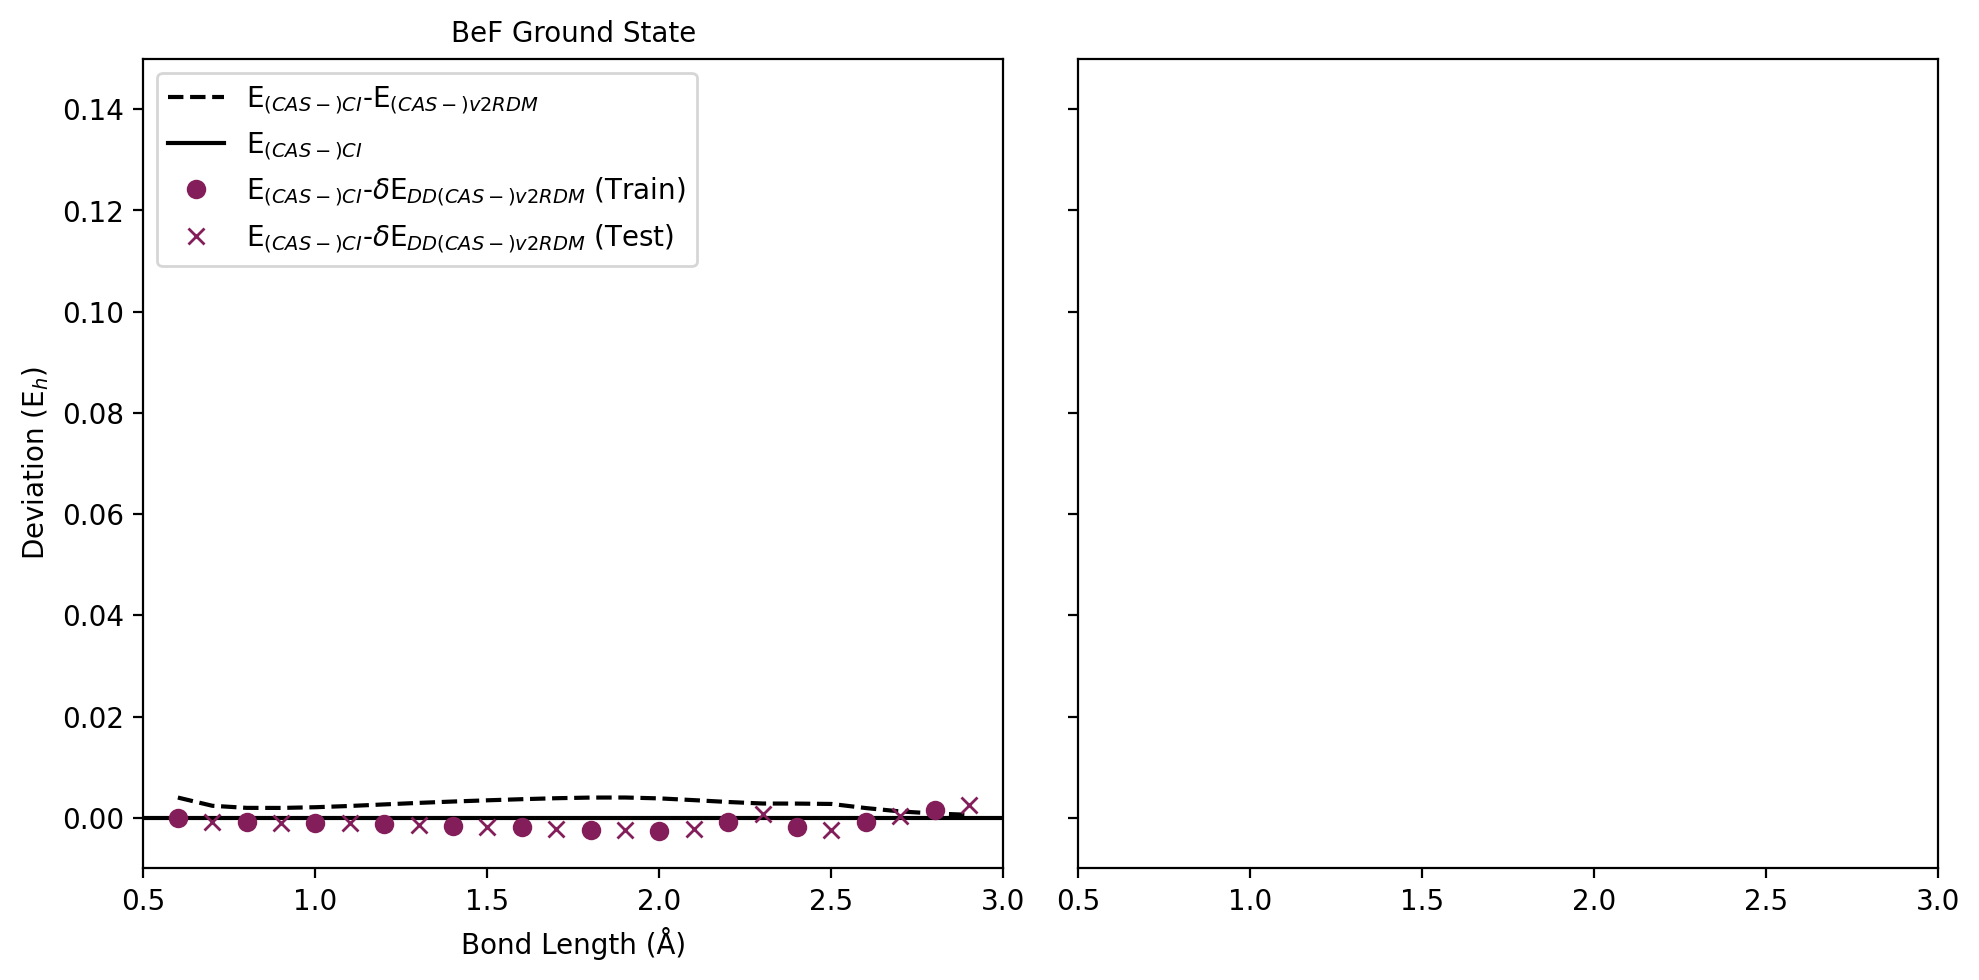

BeN BeN_triplet_quartet BeN_singlet_doublet


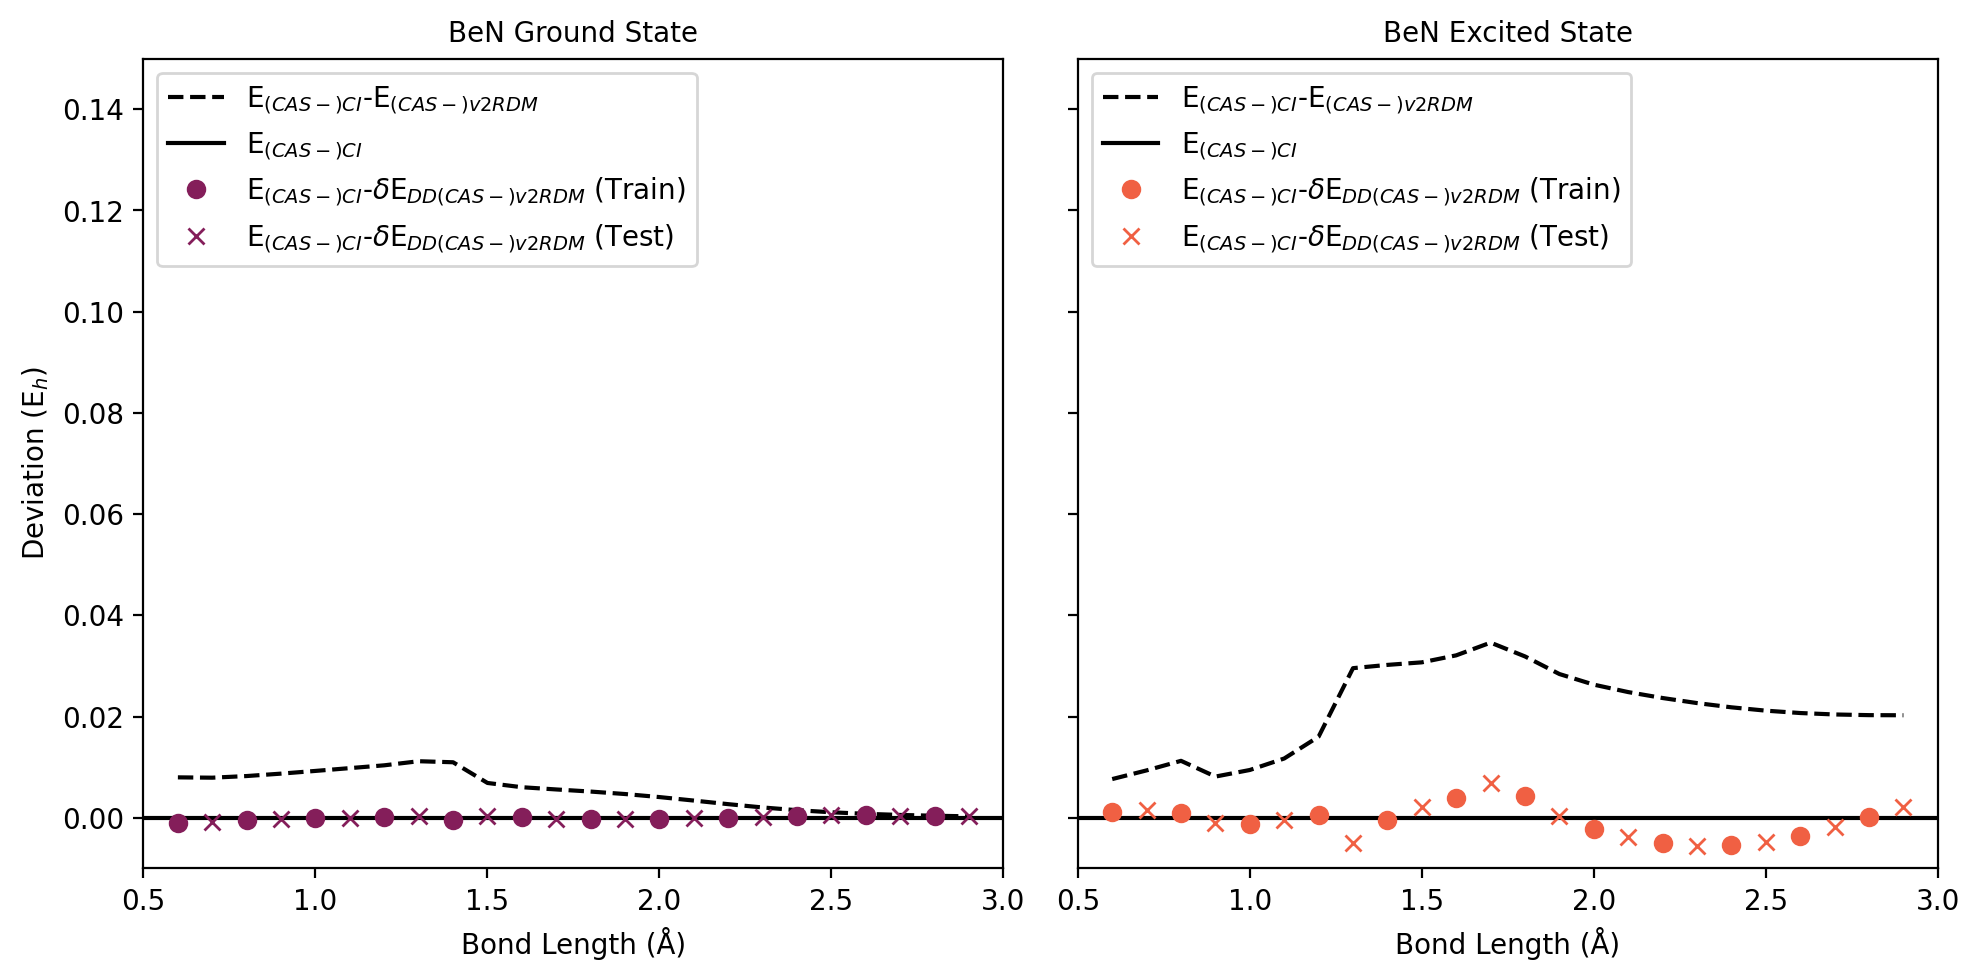

BeO BeO_singlet_doublet BeO_triplet_quartet


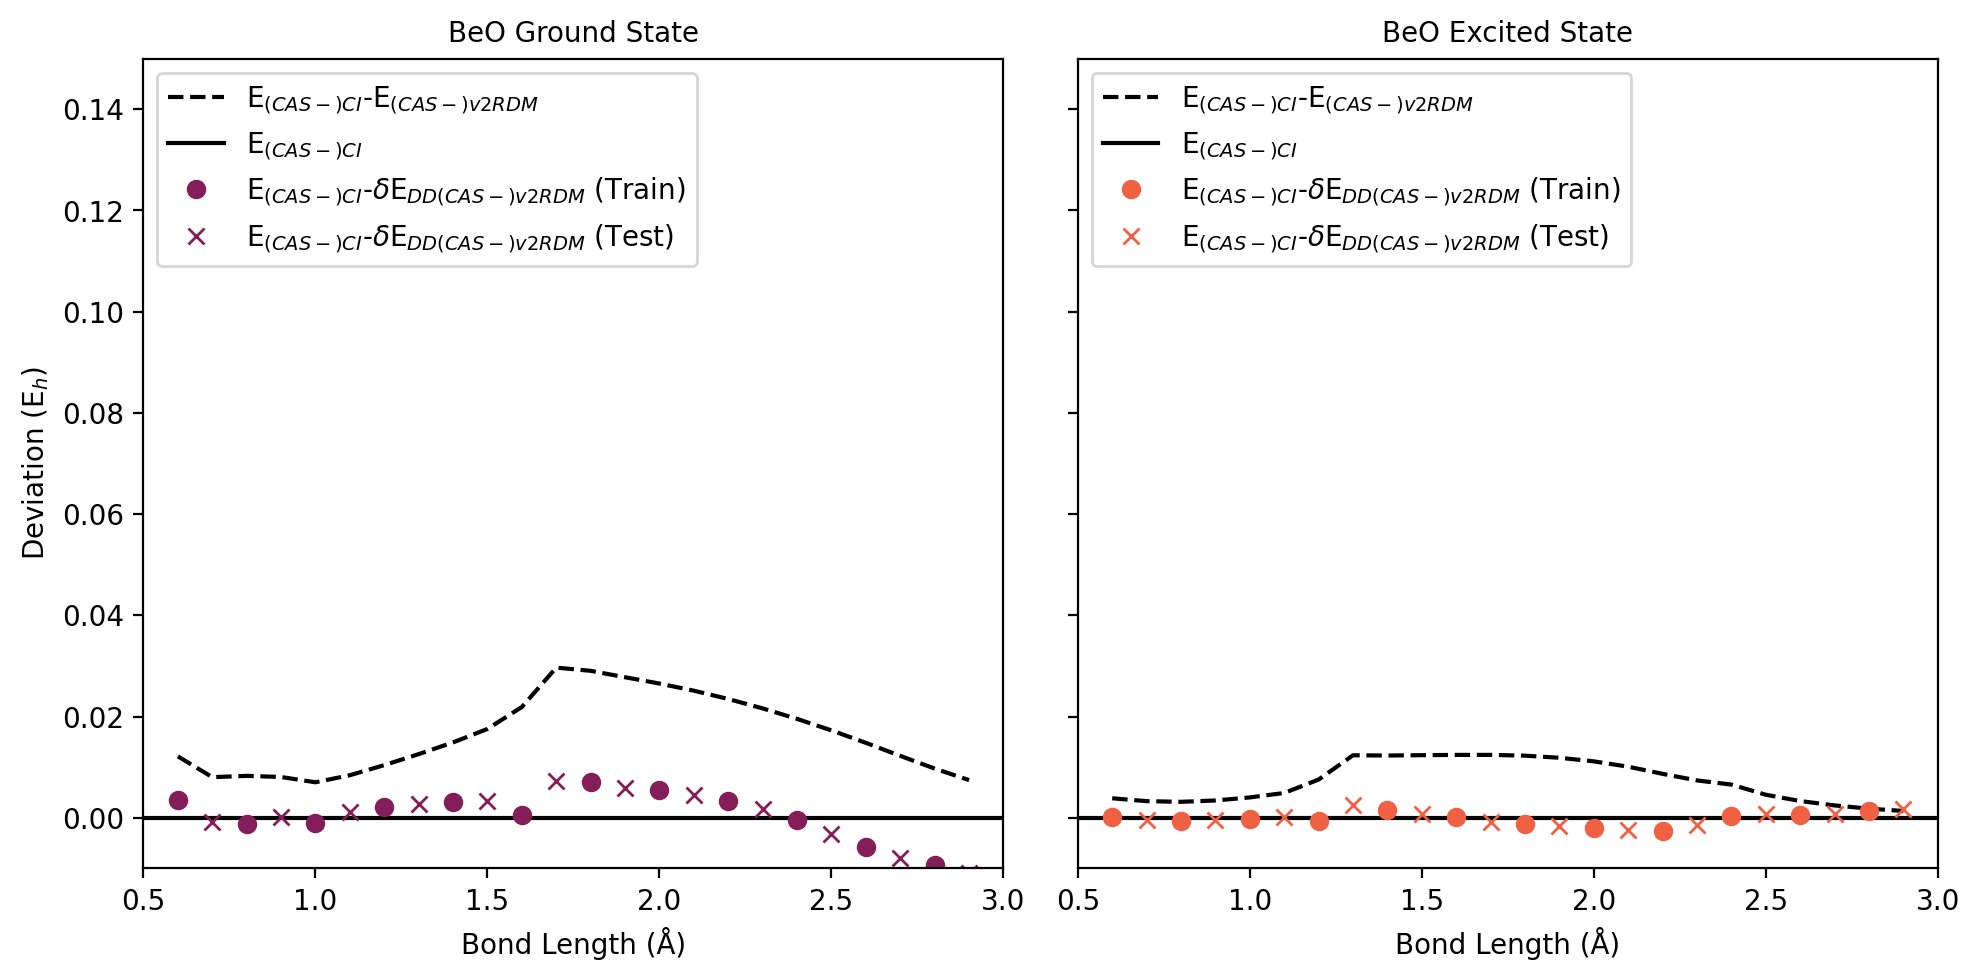

CC CC_singlet_doublet CC_triplet_quartet


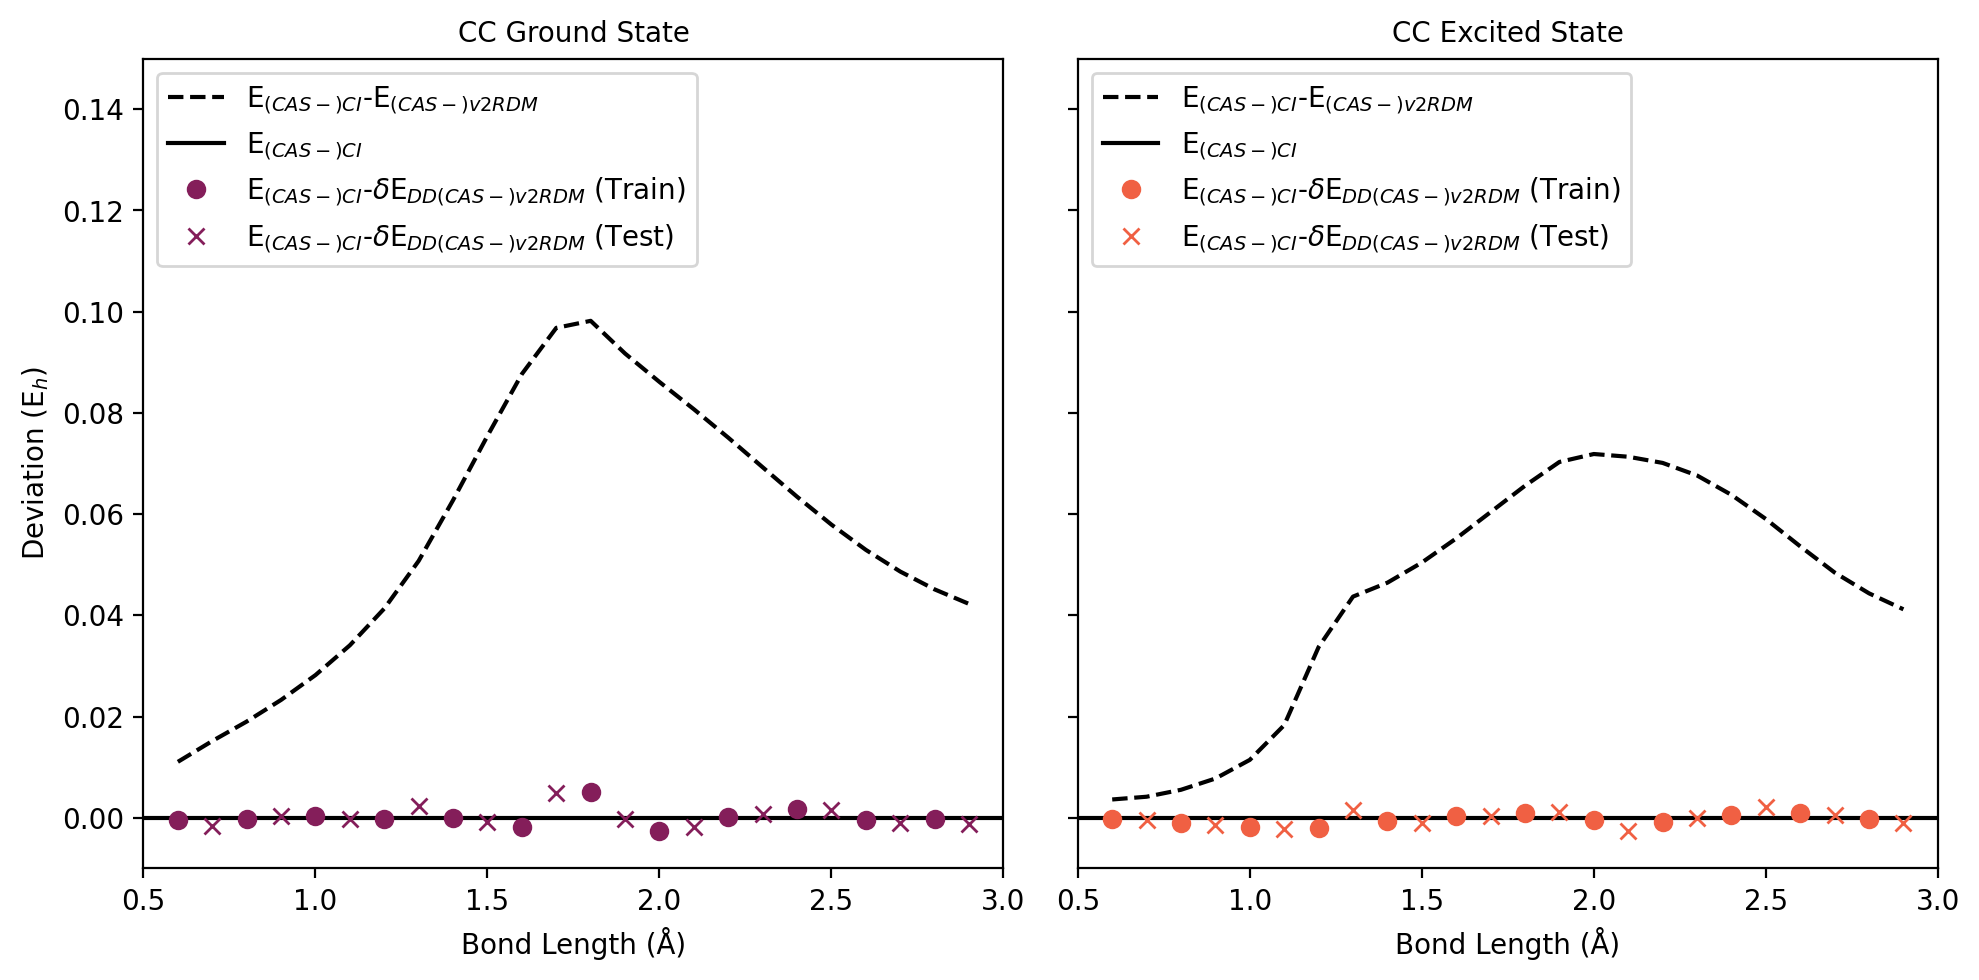

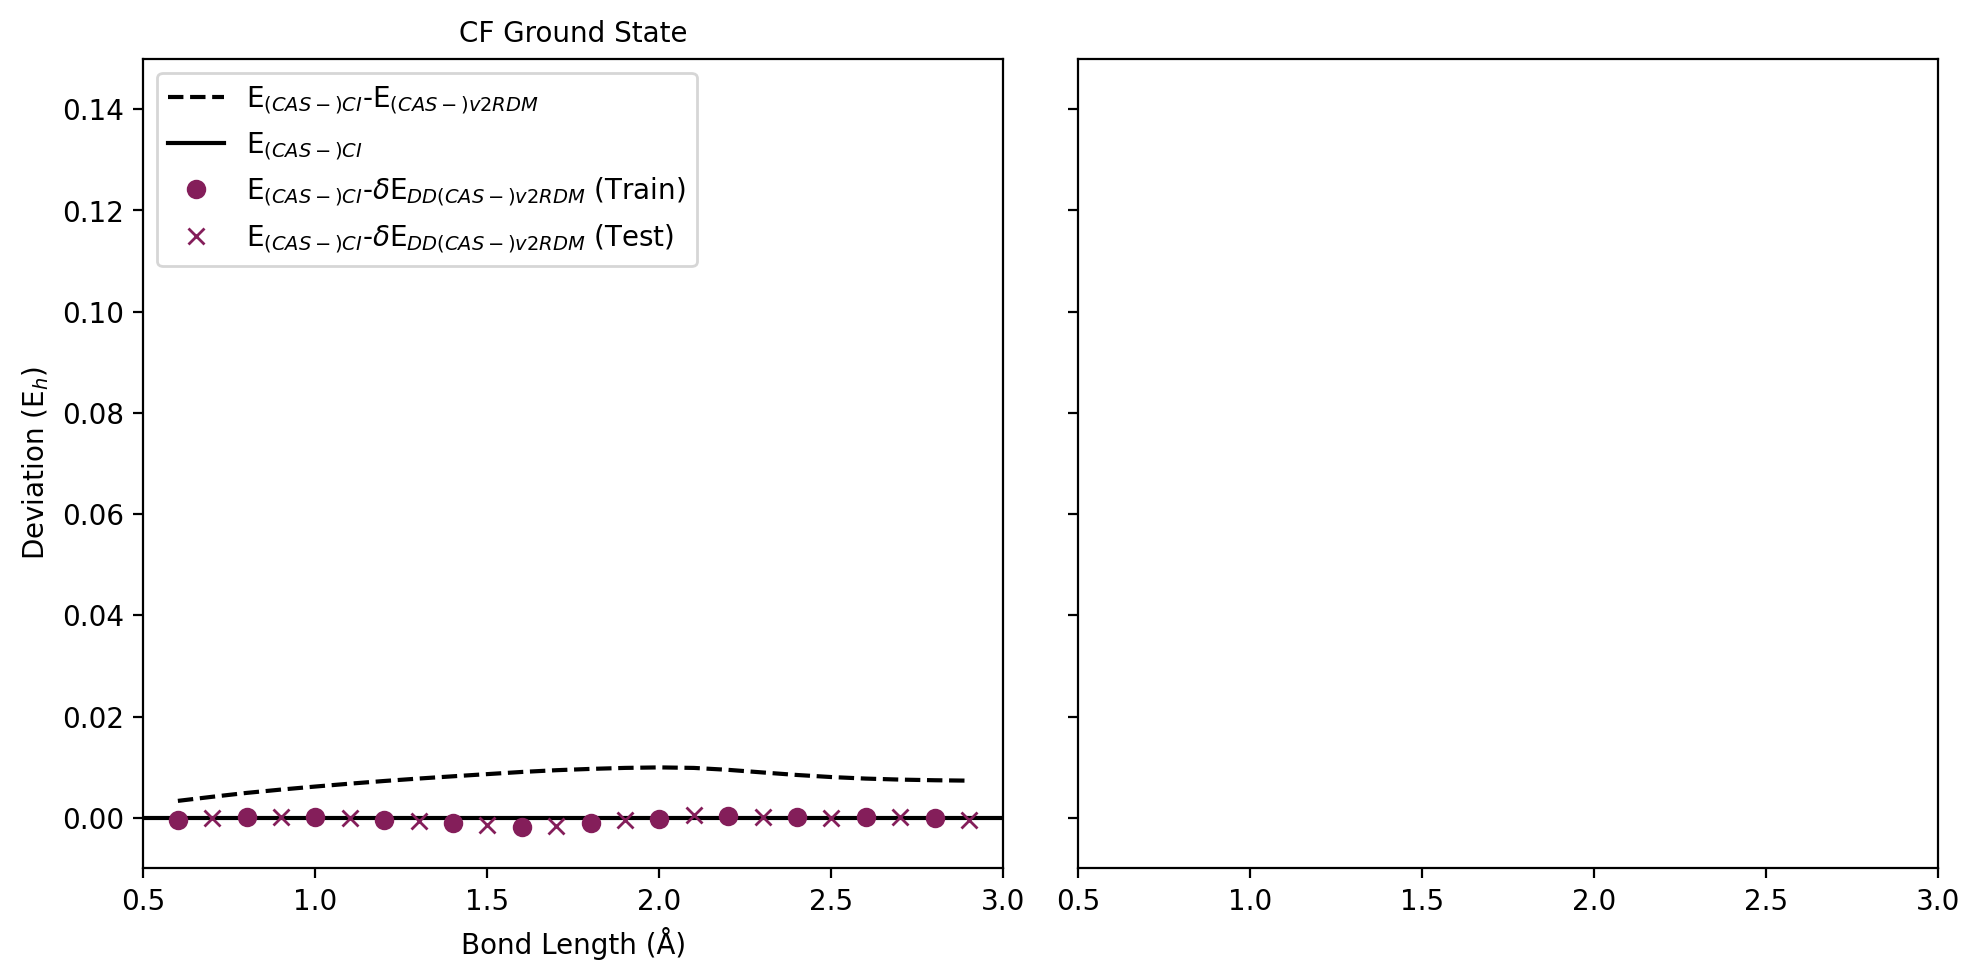

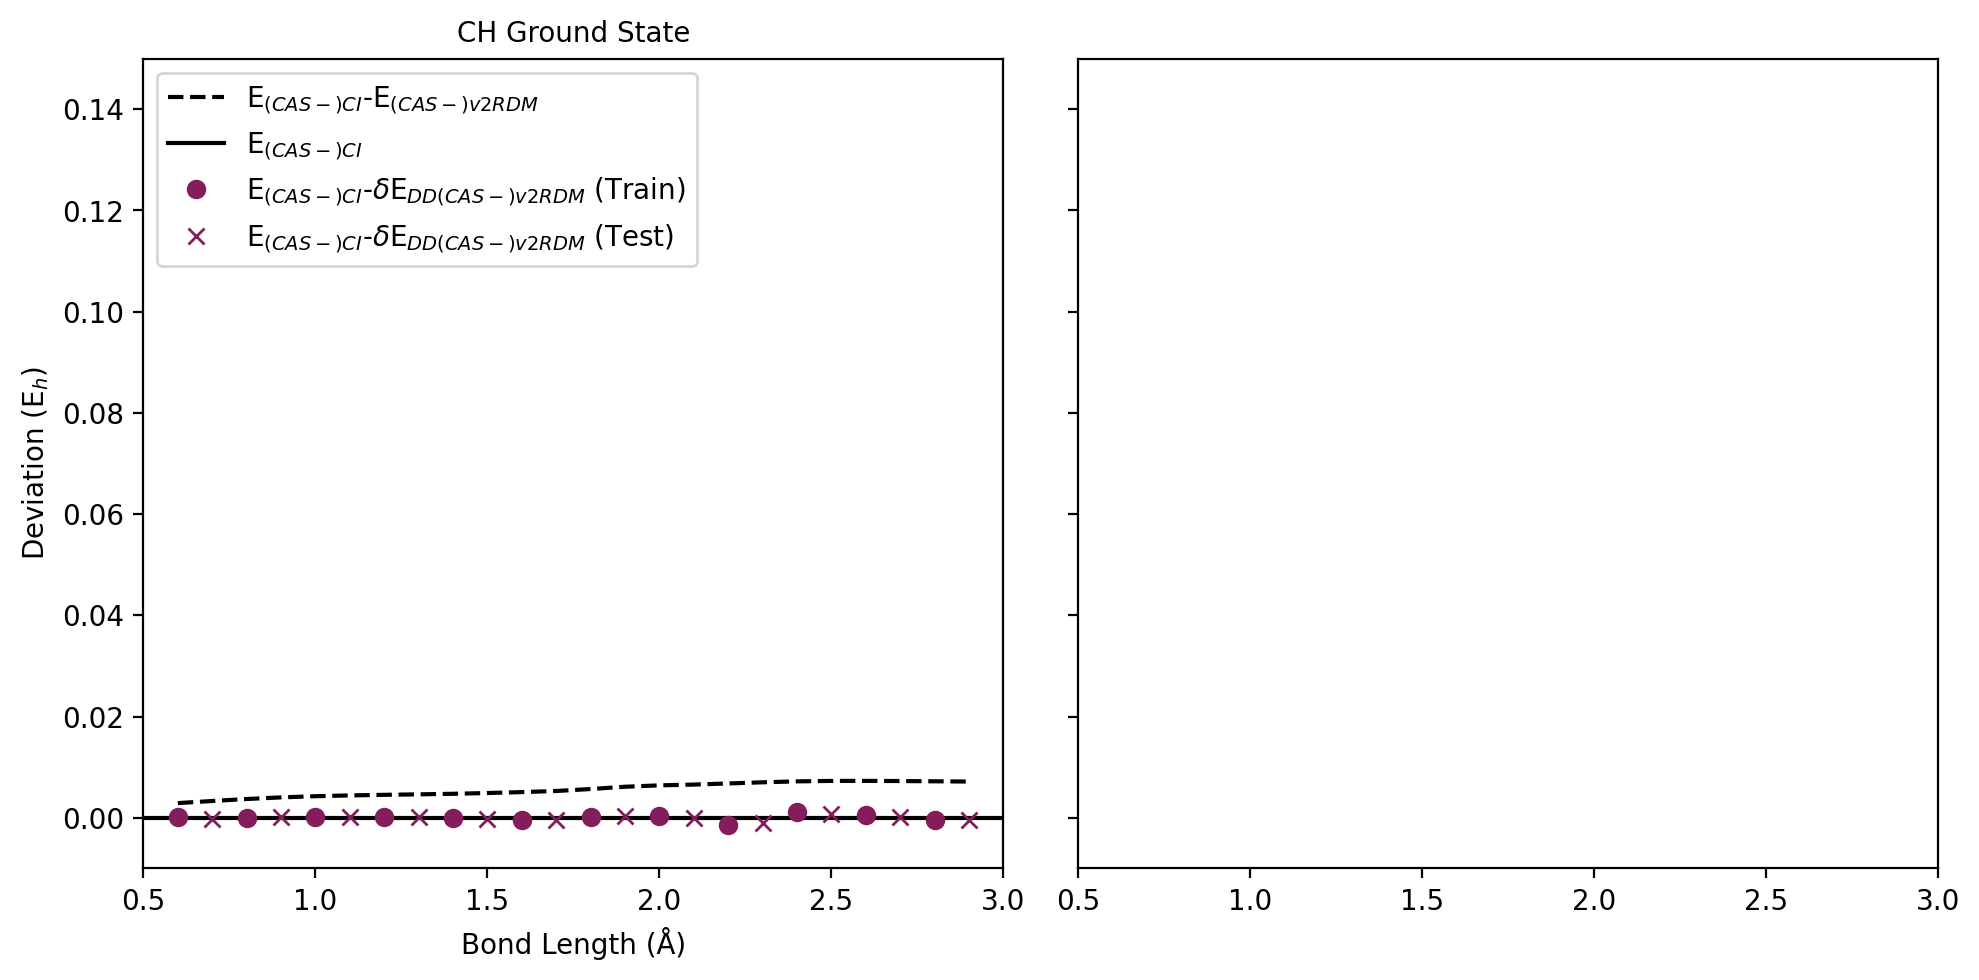

CN CN_singlet_doublet CN_triplet_quartet


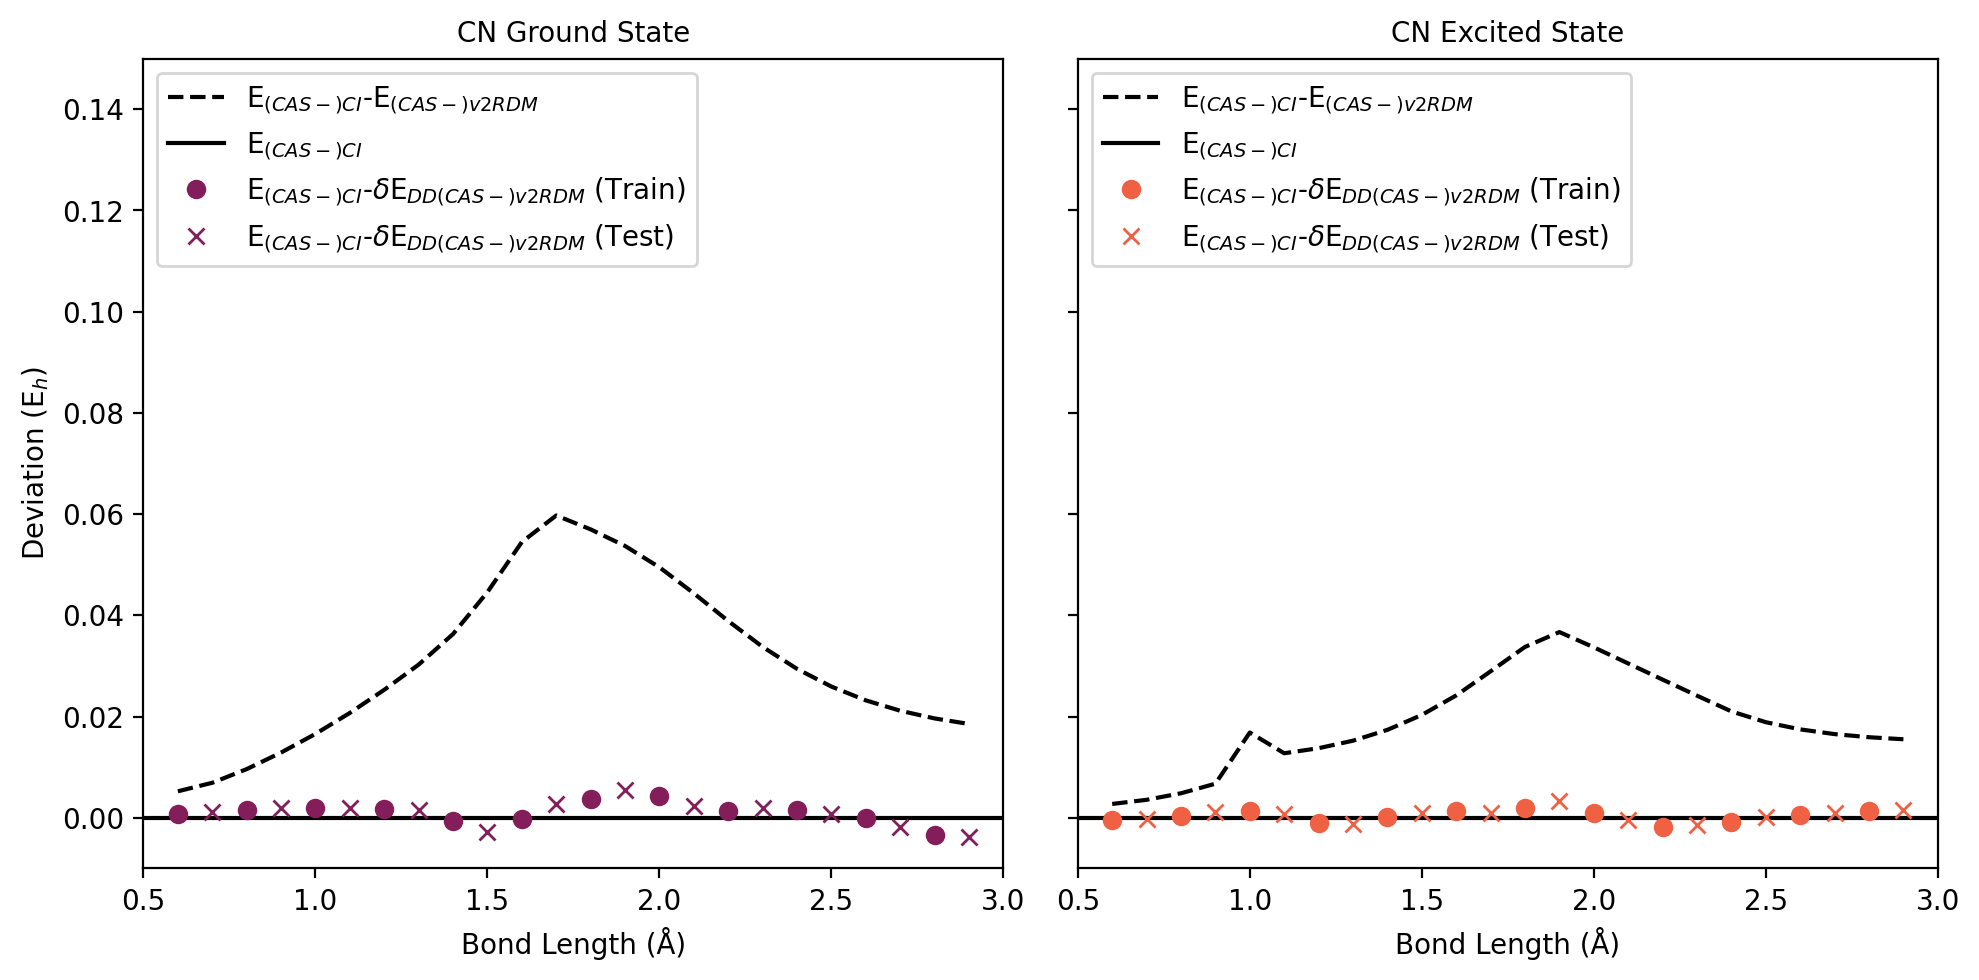

CO CO_singlet_doublet CO_triplet_quartet


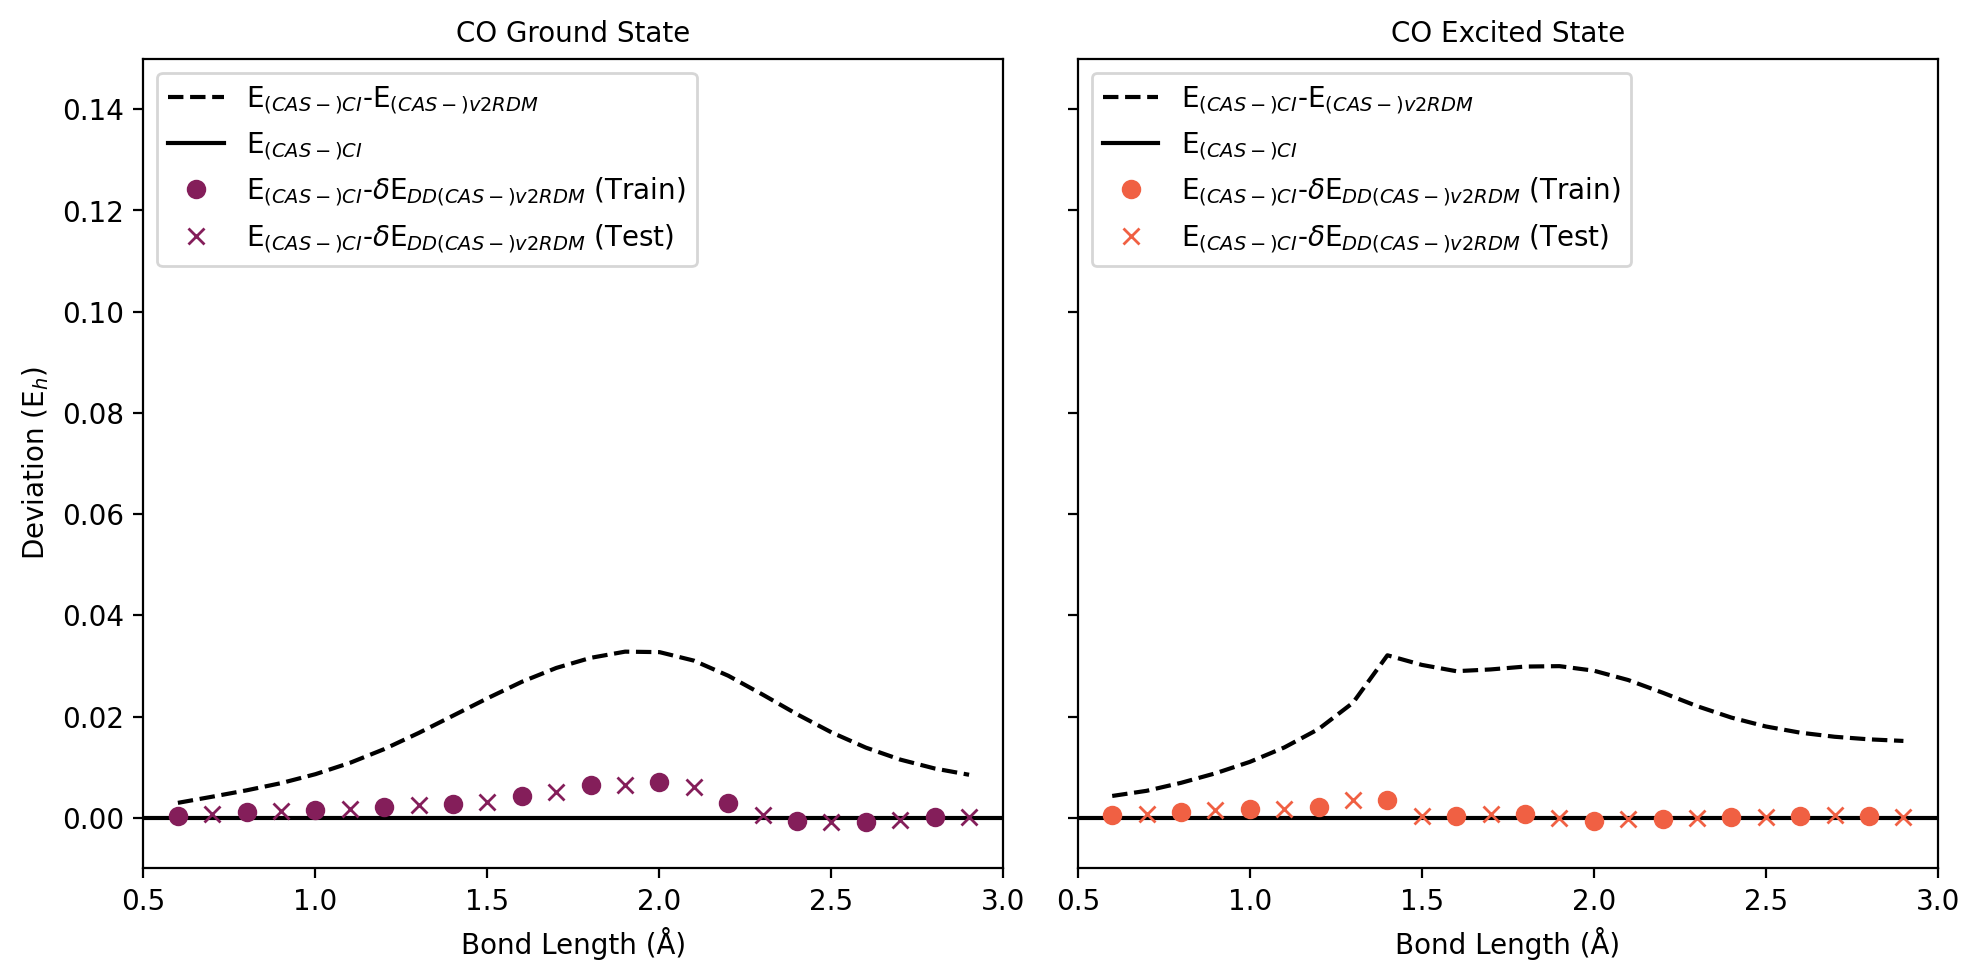

LiN LiN_triplet_quartet LiN_singlet_doublet


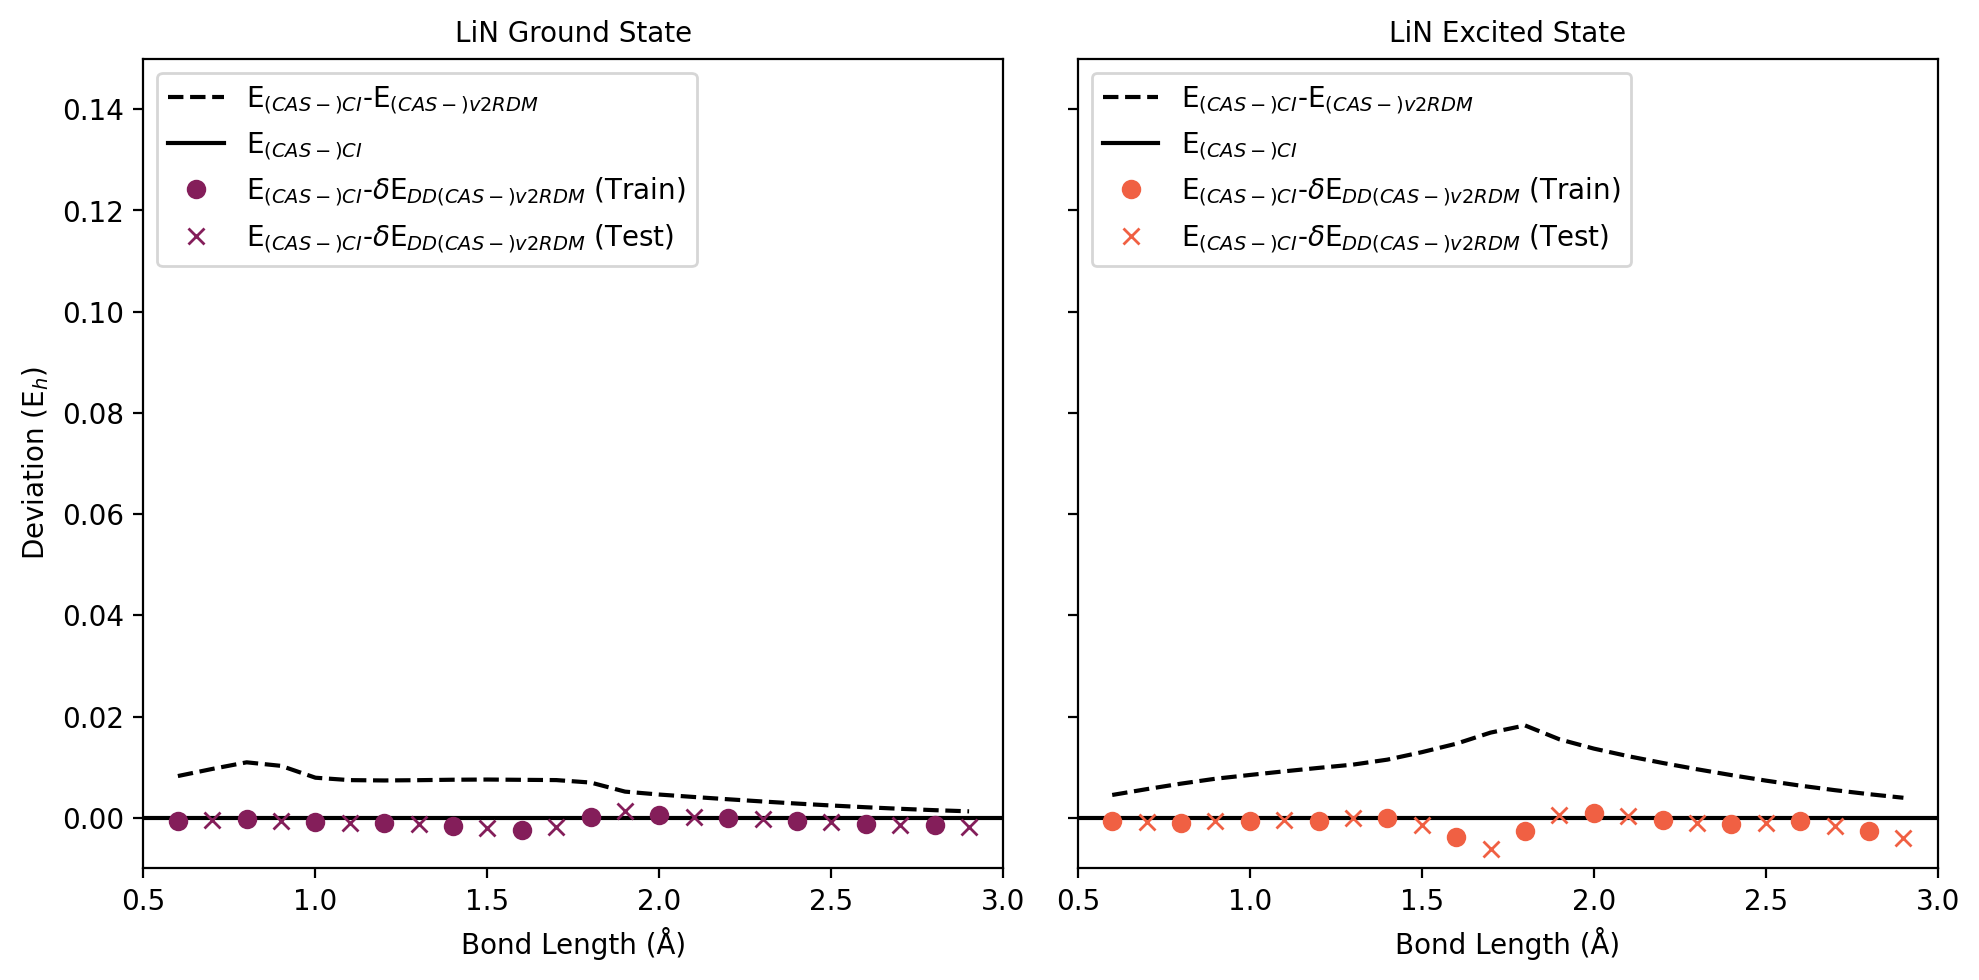

NN NN_singlet_doublet NN_triplet_quartet


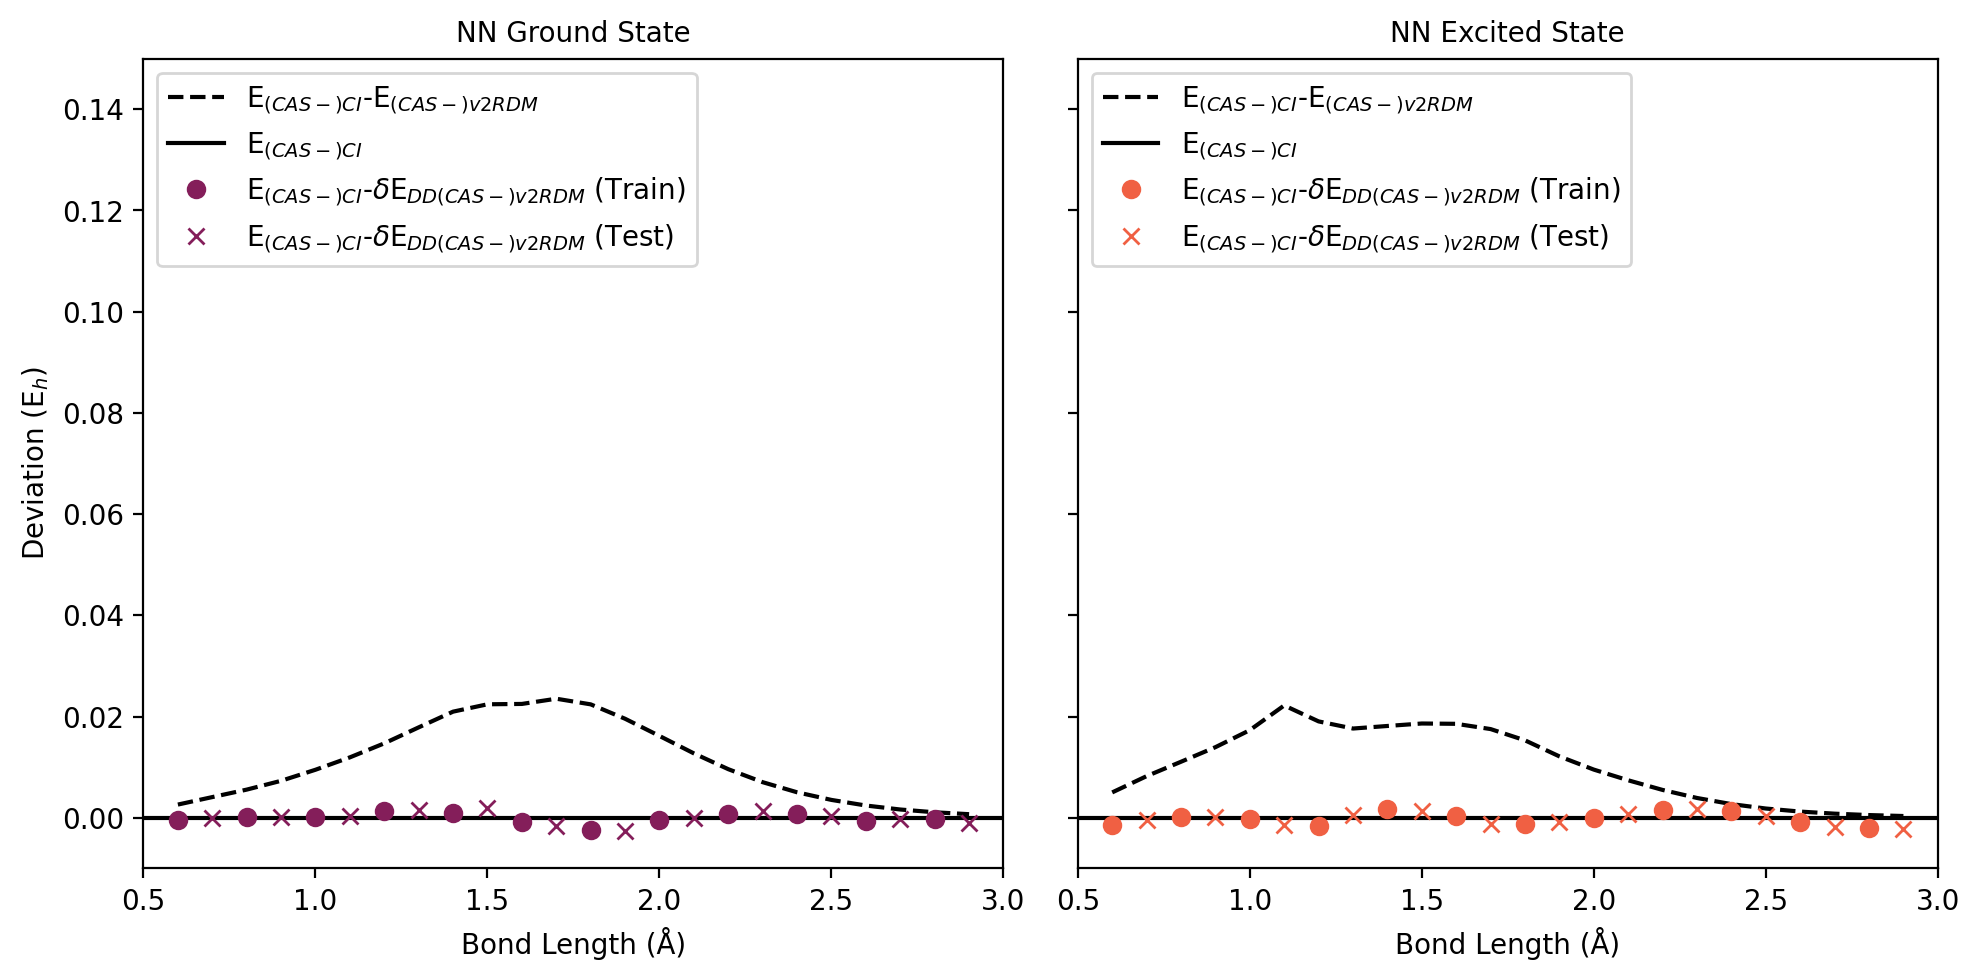

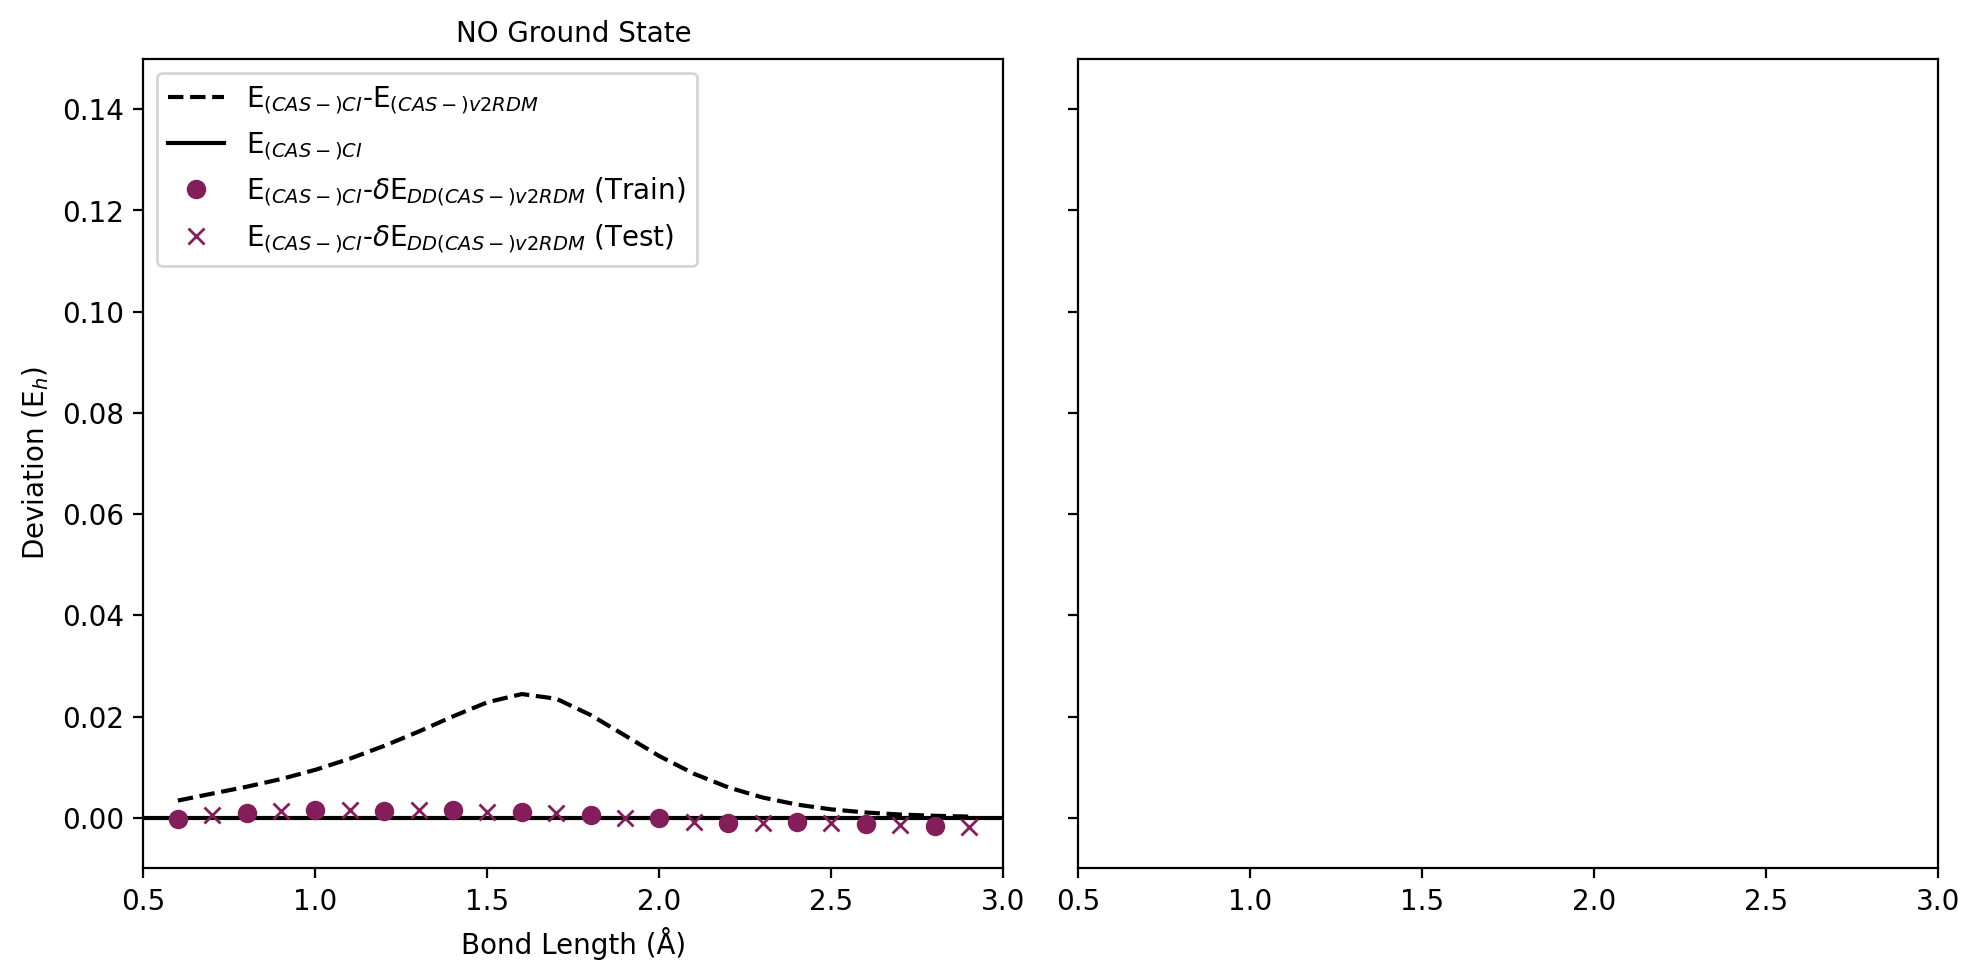

OO OO_triplet_quartet OO_singlet_doublet


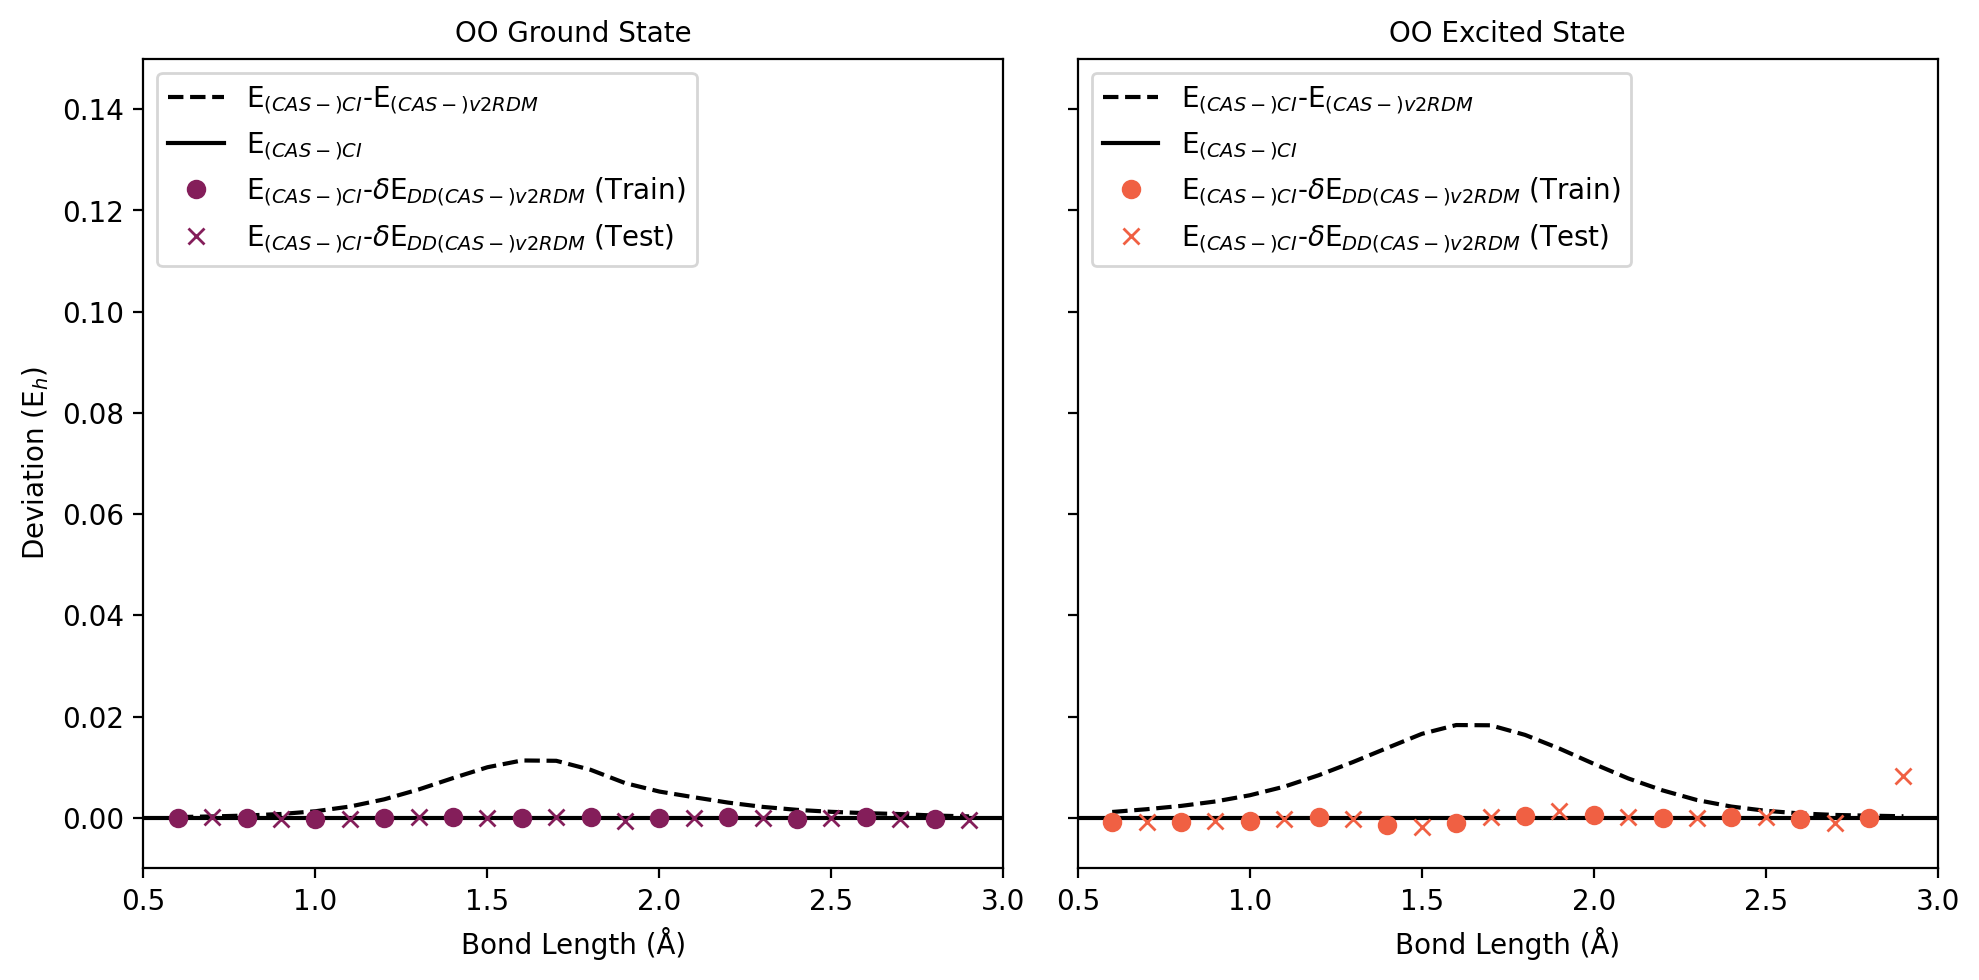

In [53]:
fontsize = 10
plt.rcParams.update({'font.size': fontsize})
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

for idx,nam in enumerate(GS_df.columns):
    fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
    if 'triplet_quartet' in nam:
        i=nam.replace('_triplet_quartet','')
    if 'singlet_doublet' in nam:
        i=nam.replace('_singlet_doublet','')
        
    GS_CI,GS_rdm=GS_energies[i]['FCI'],GS_energies[i]['v2RDM']
    ES_CI,ES_rdm=ES_energies[i]['FCI'],ES_energies[i]['v2RDM']

    for j in list(GS_df.columns):
        if f'{i}_' in j:
            train=key_train[j]
            test=key_test[j]
            
            ax[0].plot(GS_df[j],'k--',label='E$_{(CAS-)CI}$-E$_{(CAS-)v2RDM}$')
            ax[0].plot(range(len(GS_df[j])),len(GS_df[j])*[0],'k-',label='E$_{(CAS-)CI}$')
            ax[0].plot(GS_CI.loc[train]-(GS_ytrain_preddf[j]+GS_rdm.loc[train]),'o',color=colormap[0],label='E$_{(CAS-)CI}$-$\delta$E$_{DD(CAS-)v2RDM}$ (Train)')
            ax[0].plot(GS_CI.loc[test]-(GS_ytest_preddf[j]+GS_rdm.loc[test]),'x',color=colormap[0],label='E$_{(CAS-)CI}$-$\delta$E$_{DD(CAS-)v2RDM}$ (Test)')
            
            ax[0].set_xlim(.5,3)
            ax[0].set_ylim(-0.01,0.15)
            ax[0].legend(loc=2)
            ax[0].set_ylabel('Deviation (E$_{h}$)')
            ax[0].set_title(f'{i} Ground State')
            ax[0].set_xlabel('Bond Length (Å)')            

    for j in list(ES_df.columns):
        if f'{i}_' in j:     
            print(i,nam,j)
            train=key_train[j]
            test=key_test[j]
            
            ax[1].plot(ES_df[j],'k--',label='E$_{(CAS-)CI}$-E$_{(CAS-)v2RDM}$')
            ax[1].plot(range(len(ES_df[j])),len(ES_df[j])*[0],'k-',label='E$_{(CAS-)CI}$')
            ax[1].plot(ES_CI.loc[train]-(ES_ytrain_preddf[j]+ES_rdm.loc[train]),'o',color=colormap[1],label='E$_{(CAS-)CI}$-$\delta$E$_{DD(CAS-)v2RDM}$ (Train)')
            ax[1].plot(ES_CI.loc[test]-(ES_ytest_preddf[j]+ES_rdm.loc[test]),'x',color=colormap[1],label='E$_{(CAS-)CI}$-$\delta$E$_{DD(CAS-)v2RDM}$ (Test)')
        
            ax[1].set_xlim(.5,3)
            ax[1].legend(loc=2)
            ax[1].set_title(f'{i} Excited State')            
            ax[1].set_xlabel('Bond Length (Å)')            
    # if idx==21:
        
        

    plt.tight_layout()
    plt.savefig(f'STO-3G_bigstack_stacked_{idx}.png',dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fontsize = 16
plt.rcParams.update({'font.size': fontsize})
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

train_plot=pd.DataFrame([y_train,train_pred],index=['True Train','Predicted Train']).T
test_plot=pd.DataFrame([y_test,test_pred],index=['True Test','Predicted Test']).T

fig, axes = plt.subplots(figsize=(15,7),nrows=1, ncols=2)


axes[0].scatter(train_plot['True Train'],train_plot['Predicted Train'],color = colormap[0],edgecolors='k')
axes[0].text(train_plot['True Train'].quantile(0.25),train_plot['True Train'].max()-train_plot['True Train'].quantile(0.25),r"R$^{2}$="+f"{r2_score(train_plot['True Train'],train_plot['Predicted Train']):.4f}\nRMSE={mean_squared_error(train_plot['True Train'],train_plot['Predicted Train'],squared=False):.4e}"+r" E$_{h}$")

minx=-5e-3
maxx=max(train_plot['True Train'])+max(train_plot['True Train'])/10
axes[0].set_xlim(minx,maxx)
axes[0].set_ylim(minx,maxx)
axes[0].set_xlabel('True Target Value (E$_{h}$)')
axes[0].set_ylabel('Predicted Target Value (E$_{h}$)')    

divider = make_axes_locatable(axes[0])
axHistx = divider.append_axes("top", 1.2, pad=0.2, sharex=axes[0])
axHisty = divider.append_axes("right", 1.2, pad=0.2, sharey=axes[0])


# make some labels invisible
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 0.01
x=train_plot['True Train']
y=train_plot['Predicted Train']
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins,color=colormap[0],density=True,edgecolor='k',stacked=True)
axHisty.hist(y, bins=bins, orientation='horizontal',color=colormap[0],density=True,edgecolor='k',stacked=True)

axHistx.set_ylabel('Probability Density',fontsize=fontsize-2)

axHisty.yaxis.set_label_position("right")
# axHisty.yaxis.tick_right()
# axHisty.set_ylabel('Probability Density', rotation=270,labelpad=15)
axHisty.set_xlabel('Probability Density',fontsize=fontsize-2)

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.
axHistx.set_title('Train')
axHistx.set_yticks(np.linspace(0,70,3))
axHisty.set_xticks(np.linspace(0,70,3))



# 2
axes[1].scatter(test_plot['True Test'],test_plot['Predicted Test'],color = colormap[1],edgecolors='k')
axes[1].text(test_plot['True Test'].quantile(0.25),test_plot['True Test'].max()-test_plot['True Test'].quantile(0.25),r"R$^{2}$="+f"{r2_score(test_plot['True Test'],test_plot['Predicted Test']):.4f}\nRMSE={mean_squared_error(test_plot['True Test'],test_plot['Predicted Test'],squared=False):.4e}"+r" E$_{h}$")
minx=-5e-3
maxx=max(test_plot['True Test'])+max(test_plot['True Test'])/10
axes[1].set_xlim(minx,maxx)
axes[1].set_ylim(minx,maxx)
axes[1].set_xlabel('True Target Value (E$_{h}$)')
axes[1].set_ylabel('Predicted Target Value (E$_{h}$)')    

divider = make_axes_locatable(axes[1])
axHistx = divider.append_axes("top", 1.2, pad=0.2, sharex=axes[1])
axHisty = divider.append_axes("right", 1.2, pad=0.2, sharey=axes[1])


# make some labels invisible
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
x=test_plot['True Test']
y=test_plot['Predicted Test']
binwidth = 0.01
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins,color=colormap[1],density=True,edgecolor='k',stacked=True)
axHisty.hist(y, bins=bins, orientation='horizontal',color=colormap[1],density=True,edgecolor='k',stacked=True)

axHistx.set_ylabel('Probability Density',fontsize=fontsize-2)
axHistx.set_title('Test')
axHisty.yaxis.set_label_position("right")
# axHisty.yaxis.tick_right()
# axHisty.set_ylabel('Probability Density', rotation=270,labelpad=15)
axHisty.set_xlabel('Probability Density',fontsize=fontsize-2)

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

axHistx.set_yticks(np.linspace(0,70,3))
axHisty.set_xticks(np.linspace(0,70,3))
plt.tight_layout()
plt.savefig('STO-3G_bigstack_error.png',dpi=300,bbox_inches='tight')    
plt.show()

In [32]:
sp_df=pd.concat([gs_df,es_df])
sp_df[(sp_df['spin_dir']=='singlet_doublet')&(sp_df['system']=='BC')]

spin_dir system    basis    S  2S+1
6  singlet_doublet     BC   STO-3G  0.5   2.0
7  singlet_doublet     BC    6-31G  0.5   2.0
8  singlet_doublet     BC  cc-PVDZ  0.5   2.0

In [33]:
GS_df.T.max().idxmax()

1.8

In [34]:
GS_df.T.max().max()

0.09820206803298959

In [35]:
GS_df.T.idxmax().loc[GS_df.T.max().idxmax()]

'CC_singlet_doublet'

(0.38092887, 0.12061482, 0.32506528)

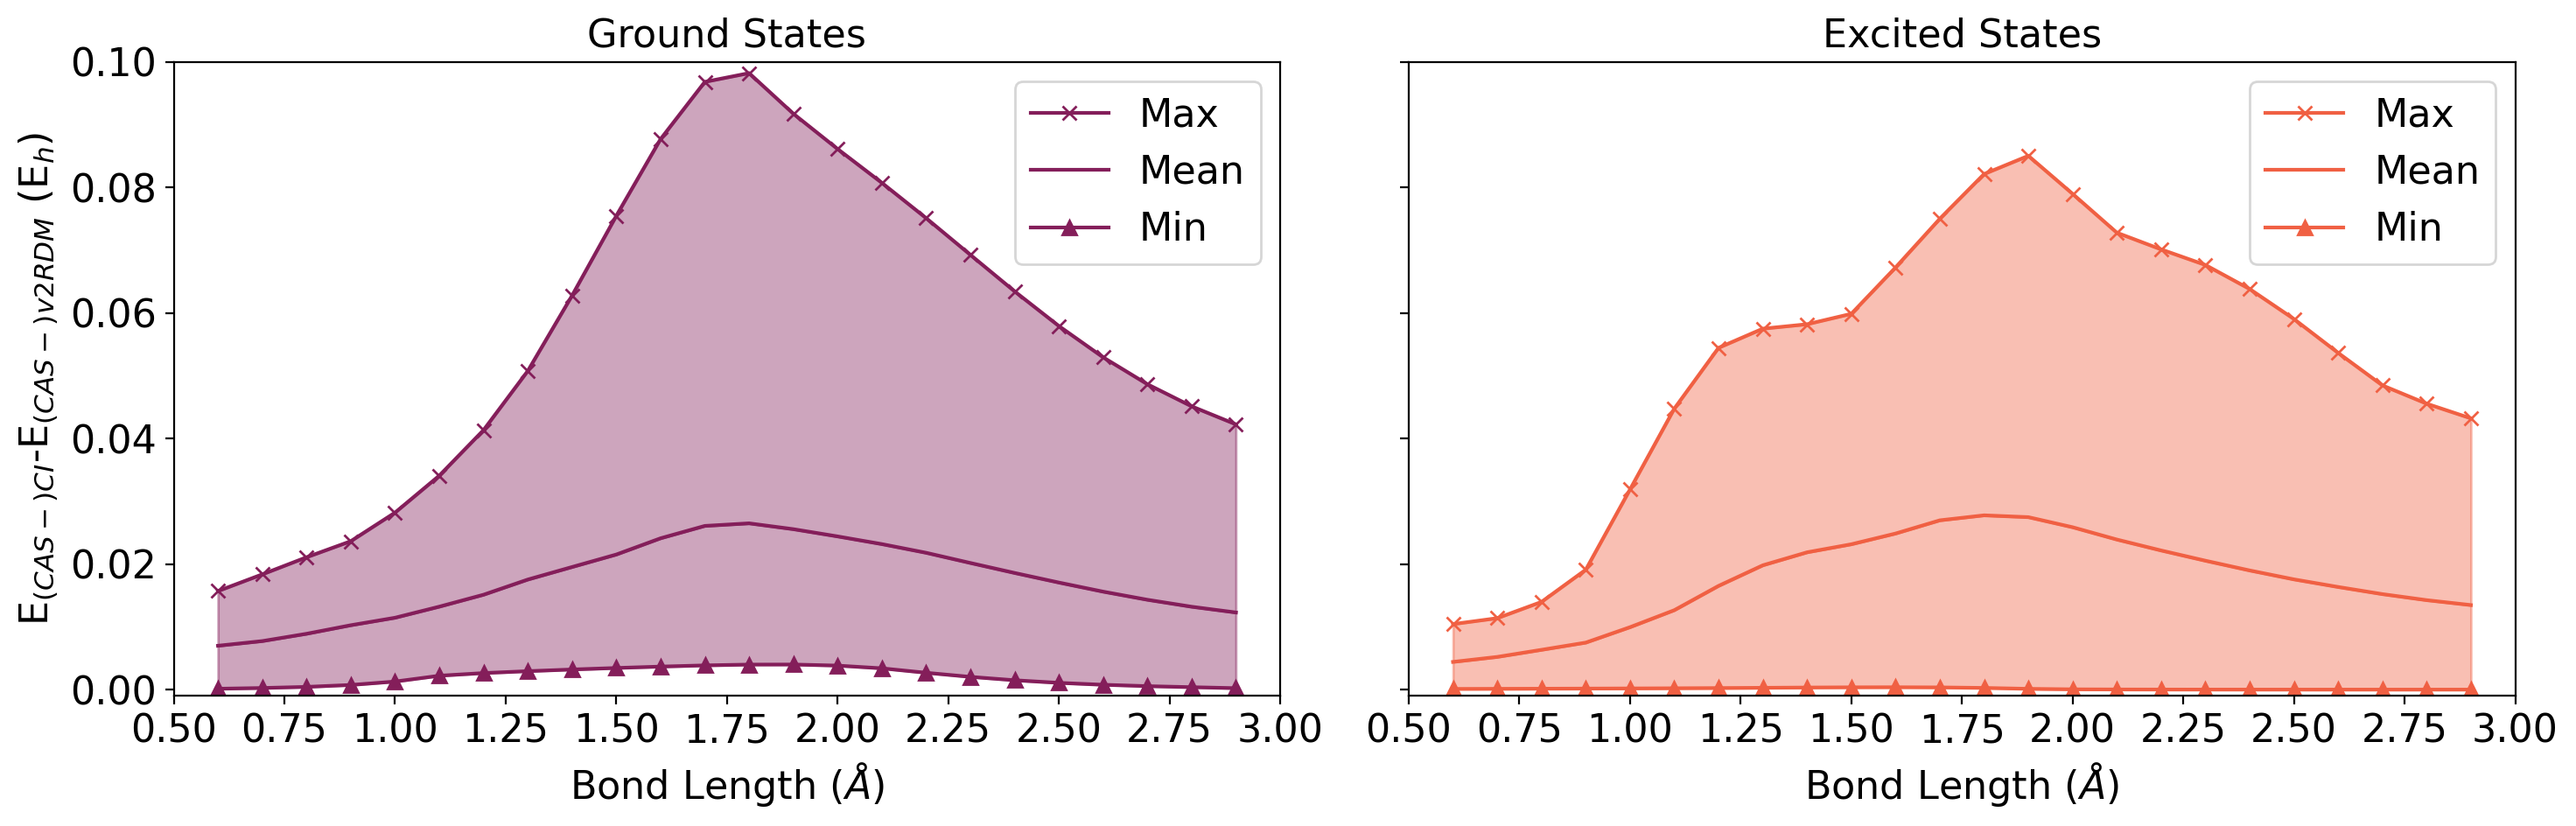

In [59]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5),sharey=True)
ax1.plot(GS_df.T.columns,GS_df.T.max(),'-x',label='Max',color=colormap[0])
ax1.plot(GS_df.T.columns,GS_df.T.mean(),'-',label='Mean',color=colormap[0])
ax1.plot(GS_df.T.columns,GS_df.T.min(),'-^',label='Min',color=colormap[0])
ax1.fill_between(GS_df.T.columns,GS_df.T.min(),GS_df.T.mean(),alpha=0.4,color=colormap[0])
ax1.fill_between(GS_df.T.columns,GS_df.T.mean(),GS_df.T.max(),alpha=0.4,color=colormap[0])
ax1.legend()
ax1.set_xticks(np.linspace(0.5,4,15))
ax1.set_xlim(0.5,3)
ax1.set_ylim(-0.001,0.10)

ax1.set_xlabel('Bond Length ($\AA$)')
ax1.set_ylabel('E$_{(CAS-)CI}$-E$_{(CAS-)v2RDM}$ (E$_{h}$)')
ax1.set_title('Ground States')

ax2.plot(ES_df.T.columns,ES_df.T.max(),'-x',label='Max',color=colormap[1])
ax2.plot(ES_df.T.columns,ES_df.T.mean(),'-',label='Mean',color=colormap[1])
ax2.plot(ES_df.T.columns,ES_df.T.min(),'-^',label='Min',color=colormap[1])
ax2.fill_between(ES_df.T.columns,ES_df.T.min(),ES_df.T.mean(),alpha=0.4,color=colormap[1])
ax2.fill_between(ES_df.T.columns,ES_df.T.max(),ES_df.T.mean(),alpha=0.4,color=colormap[1])
ax2.set_xticks(np.linspace(0.5,4,15))
ax2.set_xlim(0.5,3)
ax2.set_xlabel('Bond Length ($\AA$)')
ax2.set_title('Excited States')
ax2.legend()
plt.tight_layout()
plt.savefig('GS_ES_spreads.png',dpi=300,bbox_inches='tight')
plt.show()

In [37]:
ax2.get_xticklabels()

[Text(0.5, 0, '0.50'),
 Text(0.75, 0, '0.75'),
 Text(1.0, 0, '1.00'),
 Text(1.25, 0, '1.25'),
 Text(1.5, 0, '1.50'),
 Text(1.75, 0, '1.75'),
 Text(2.0, 0, '2.00'),
 Text(2.25, 0, '2.25'),
 Text(2.5, 0, '2.50'),
 Text(2.75, 0, '2.75'),
 Text(3.0, 0, '3.00'),
 Text(3.25, 0, '3.25'),
 Text(3.5, 0, '3.50'),
 Text(3.75, 0, '3.75'),
 Text(4.0, 0, '4.00')]

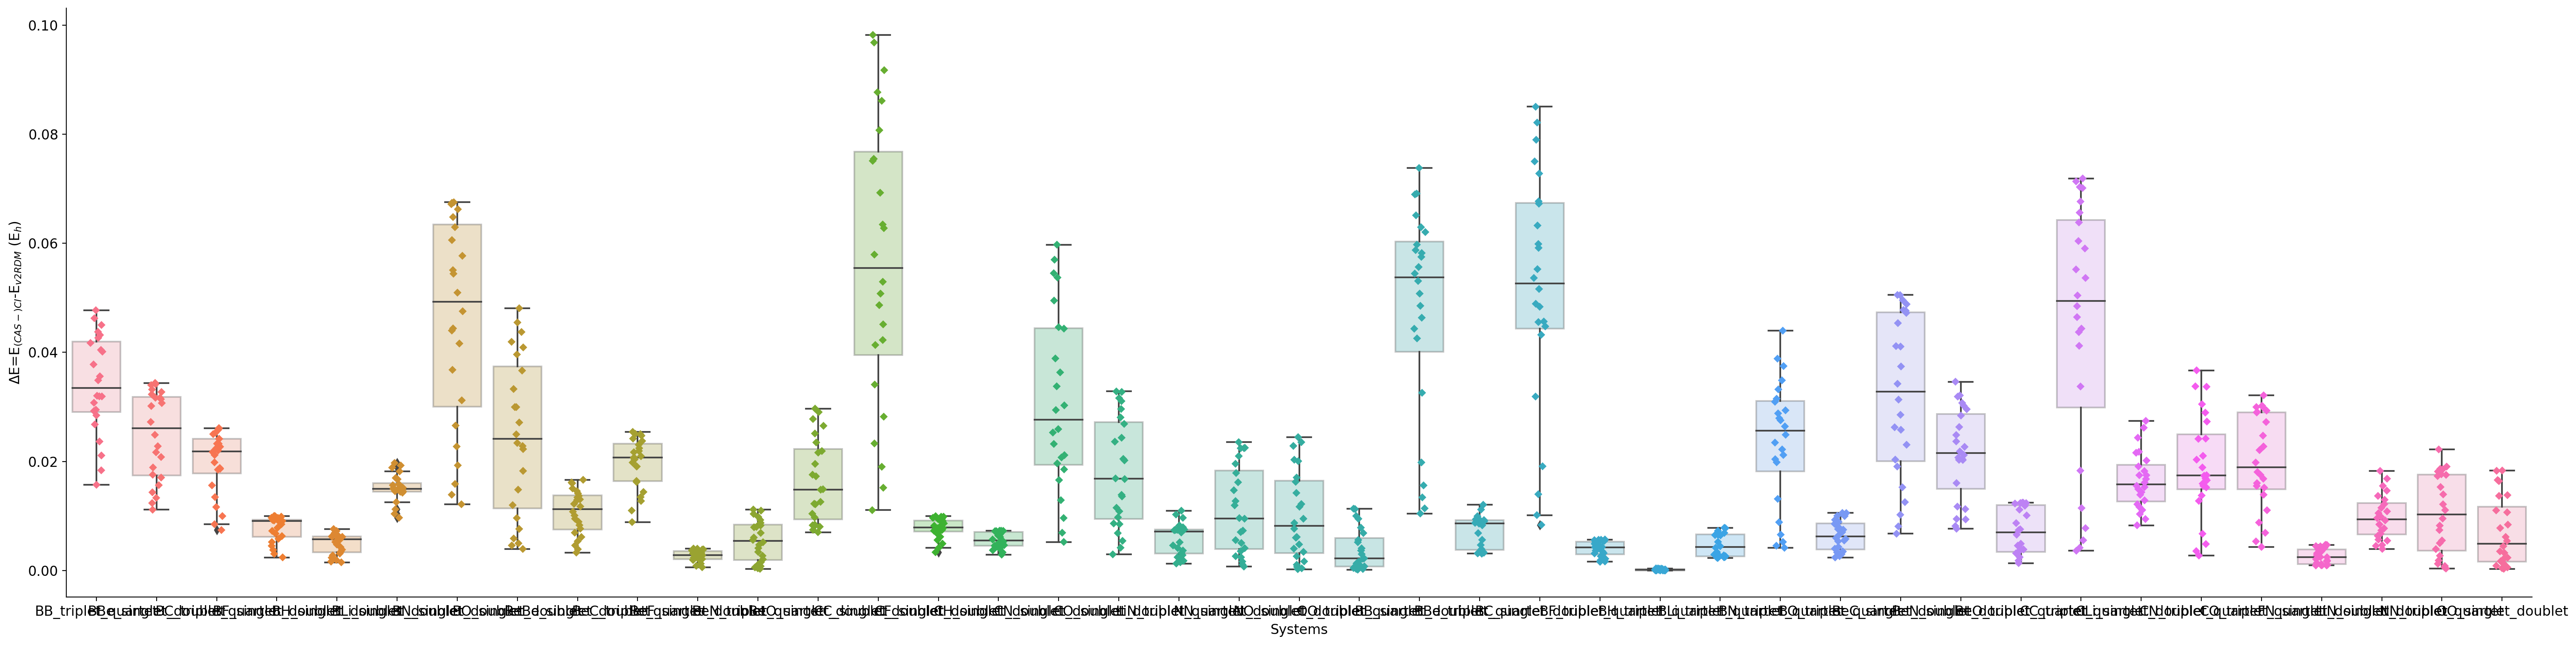

In [38]:

plt.rcParams.update({'font.size': 18})
sns.catplot(data=Y, height=8.27, aspect=32/8.27,marker='D')
sns.boxplot(data=Y, boxprops=dict(alpha=.3))
# sns.despine(offset=10, trim=False)
plt.xlabel('Systems')
plt.ylabel('$\Delta$E=E$_{(CAS-)CI}$-E$_{v2RDM}$ (E$_{h}$)')

plt.tight_layout()
# plt.savefig('STO-3G_system_stripandbox.png',dpi=600)
plt.show()
# sns.swarmplot(data=Y, size=3)

In [39]:
# fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
# true_Y=Y.T.stack().to_numpy()
# train_plot=pd.DataFrame([y_train,train_pred],index=['True Train','Predicted Train']).T
# test_plot=pd.DataFrame([y_test,test_pred],index=['True Test','Predicted Test']).T

# sns.scatterplot(data=train_plot,x='True Train',y='Predicted Train',ax=ax1,label='Train')
# sns.scatterplot(data=test_plot,x='True Test',y='Predicted Test',ax=ax1,label='Test')
# ax1.plot(true_Y,true_Y,'k')
# ax1.set_xlim(-1e-3,0.063)
# ax1.set_ylim(-1e-3,0.063)
# ax1.legend()
# ax1.set_xlabel('True Target Values (E$_{h}$)')
# ax1.set_ylabel('Predicted Target Values (E$_{h}$)')

# sns.histplot(data=train_plot,ax=ax2)
# ax2.set_xlabel('Train Target Values (E$_{h}$)')

# sns.histplot(data=test_plot,ax=ax3)
# ax3.set_xlabel('Test Target Values (E$_{h}$)')
# plt.tight_layout()
# plt.savefig('STO-3G_bigstack_error.png',dpi=300,bbox_inches='tight')
# plt.show()

In [40]:

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = len(x)//20
    print(bins)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

In [41]:
[i for i in dir(plt.figure()) if 'key' in i]

['_mouse_key_ids']

<Figure size 1280x960 with 0 Axes>

In [42]:


statdf=pd.DataFrame(columns=system_dict.keys(),index=['Train R2','Test R2','Train MAPE','Test MAPE','Train RMSE','Test RMSE','State','system'])
survived_ES=set(statdf.columns).intersection(set([sy+'_'+st for st,sy,bs in excitedstates if bs==basis]))
survived_GS=set(statdf.columns).intersection(set([sy+'_'+st for st,sy,bs in groundstates if bs==basis]))

print(len(survived_ES)+len(survived_GS)==len(statdf.columns))

for i in system_dict.keys():
    statdf[i].loc['system']=i.split('_')[0]
    statdf[i].loc['Train R2']=r2_score(ytraindf[i].dropna(),ytrain_preddf[i].dropna())
    statdf[i].loc['Test R2']=r2_score(ytestdf[i].dropna(),ytest_preddf[i].dropna())
    statdf[i].loc['Train MAPE']=mean_absolute_percentage_error(ytraindf[i].dropna(),ytrain_preddf[i].dropna())
    statdf[i].loc['Test MAPE']=mean_absolute_percentage_error(ytestdf[i].dropna(),ytest_preddf[i].dropna())
    statdf[i].loc['Train RMSE']=mean_squared_error(ytraindf[i].dropna(),ytrain_preddf[i].dropna(), squared=False)
    statdf[i].loc['Test RMSE']=mean_squared_error(ytestdf[i].dropna(),ytest_preddf[i].dropna(), squared=False)
for i in list(survived_ES):
    statdf[i].loc['State']='ES'
for i in list(survived_GS): 
    statdf[i].loc['State']='GS'   
    
statdf.to_excel('STO-3G_stats.xlsx')


True


In [43]:
statdf

BB_triplet_quartet BBe_singlet_doublet BC_triplet_quartet  \
Train R2             0.986221            0.914831           0.964765   
Test R2              0.969223            0.896969           0.933667   
Train MAPE           0.027286            0.077909           0.050754   
Test MAPE            0.039848            0.086738           0.054171   
Train RMSE           0.001082             0.00238           0.001105   
Test RMSE            0.001475            0.002463           0.001381   
State                      GS                  GS                 GS   
system                     BB                 BBe                 BC   

           BF_singlet_doublet BH_singlet_doublet BLi_singlet_doublet  \
Train R2            -0.484265           0.919536            0.894775   
Test R2             -1.133054           0.675391            0.865345   
Train MAPE           0.286052           0.085834            0.050375   
Test MAPE            0.303444           0.126498            0.051554   
Train RMSE            0.00297           0.000527            0.000839   
Test RMSE            0.003181           0.001037            0.000848   
State                      GS                 GS                  GS   
system                     BF                 BH                 BLi   

           BN_singlet_doublet BO_singlet_doublet BeBe_singlet_doublet  \
Train R2             0.993652           0.971364             0.823855   
Test R2              0.993881           0.971013             0.941799   
Train MAPE           0.029444           0.066504             0.136684   
Test MAPE            0.034727           0.059288             0.101894   
Train RMSE           0.001559           0.002456             0.001627   
Test RMSE            0.001402           0.002347             0.001006   
State                      GS                 GS                   GS   
system                     BN                 BO                 BeBe   

           BeC_triplet_quartet  ... BeN_singlet_doublet BeO_triplet_quartet  \
Train R2              0.924464  ...            0.860648            0.900373   
Test R2               0.936182  ...            0.806943            0.896341   
Train MAPE            0.060751  ...            0.117519            0.172861   
Test MAPE              0.06647  ...            0.132075            0.243496   
Train RMSE            0.001201  ...            0.003037             0.00122   
Test RMSE             0.001232  ...            0.003599            0.001345   
State                       GS  ...                  ES                  ES   
system                     BeC  ...                 BeN                 BeO   

           CC_triplet_quartet CLi_singlet_doublet CN_triplet_quartet  \
Train R2             0.998329            0.949609           0.985301   
Test R2               0.99616            0.945337            0.97797   
Train MAPE           0.042268            0.051468           0.062168   
Test MAPE            0.050199             0.05873           0.066232   
Train RMSE           0.000974            0.001171           0.001131   
Test RMSE            0.001398            0.001135           0.001377   
State                      ES                  ES                 ES   
system                     CC                 CLi                 CN   

           CO_triplet_quartet FN_singlet_doublet LiN_singlet_doublet  \
Train R2             0.975599           0.796721            0.830133   
Test R2              0.975328           0.717024            0.646379   
Train MAPE            0.06893           0.224287            0.145253   
Test MAPE            0.060028           0.320158            0.198604   
Train RMSE           0.001399           0.000607            0.001652   
Test RMSE            0.001263           0.000716            0.002297   
State                      ES                 ES                  ES   
system                     CO                 FN                 LiN   

           NN_triplet_quartet OO_singlet_doub